# Comparación de Métodos de Predicción de Series Temporales aplicados a Acciones de MERVAL 

## Caso ALUA.BA (Aluar Aluminio Argentino S.A.I.C.) Período 2015-2021.

En este cuaderno se comparan distintos métodos de predicción de series temporales para un caso de Acciones de MERVAL obtenidas del servicio Yahoo Finance!.

El objetivo es comparar desde métodos clásicos como SARIMA hasta los más recientes como [Prophet](https://facebook.github.io/prophet/) de Facebook, incluyendo varias arquitecturas de redes neuronales.
Los métodos ensayados son:

- **Suavizado Exponencial**: Simple, Doble(Holt), Triple(Holt-Winters).
- **SARIMA**: ARMA, ARIMA, SARIMA, SARIMAX.
- Agregar! -> BATS/TBATS
- Redes Neuronales Recurrentes:
  - Long Short Term Memory Networks (LSTM): básica, bidireccional y con Autoencoders
  - GRU (Gate Recurrent Units)
- CNN (Convolutional Neural Networks)
- Facebook Prophet

Se trata el problema de predicción de una manera general sin aplicar técnicas específicas de modelos matemáticos financieros o conocimientos del mercado bursátil, por lo tanto lo aplicado debería ser trasladable a casi cualquier problema de series temporales univariable.

Cada serie temporal contiene los datos de un período:

- **Apertura (Open)**
- **Alto (High)**
- **Bajo (Low)**
- **Cierre (Close)**
- **Precio de Cierre Ajustado (Adj)**
- **Volumen (Volume)**

Se estudia e intenta predecir de a una única variable por vez. Esto deja sin explotar posibles relaciones que existan entre variables, como por ejemplo la influencia del volumen de transacciones en días previos.

In [ ]:
!pip install pmdarima # Importante! Reiniciar para seleccionar versión correcta de statmodels

In [2]:
symbol = 'ALUA.BA' #ALUA.BA Aluar Aluminio Argentino S.A.I.C. 
data_source='yahoo'
start_date = '2015-01-01'
end_date = None

In [3]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import timeit
from tqdm.notebook import tqdm

Yahoo Finance! devuelve los precios por día. Se intentará obtener una predicción para un horizonte de 64 días.

In [4]:
STEPS_TO_PREDICT = 64

## 1. Descarga del dataset

In [5]:
from pandas_datareader import data
import fix_yahoo_finance as yf

yf.pdr_override() 
df = data.get_data_yahoo(symbol, start_date, end_date)
df.head(5)

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,7.54464,7.81250,7.41071,7.80357,6.517592,334621
2015-01-05,7.81250,7.81250,7.41071,7.51786,6.278966,157214
2015-01-06,7.50893,7.50893,7.23214,7.40178,6.182015,157115
2015-01-07,7.14286,7.53571,7.14286,7.53571,6.293874,181736
2015-01-08,7.71428,7.71428,7.36607,7.53571,6.293874,288559


Se hace un remuestreo de la serie señeccionada con una frecuencia diaria. La función de agregación es el promedio y se imputan los valores faltantes con interpolación lineal.

In [6]:
series_col = 'Close'
df_resampled = df.resample('D').mean().interpolate(method='linear')
series = df_resampled[series_col]

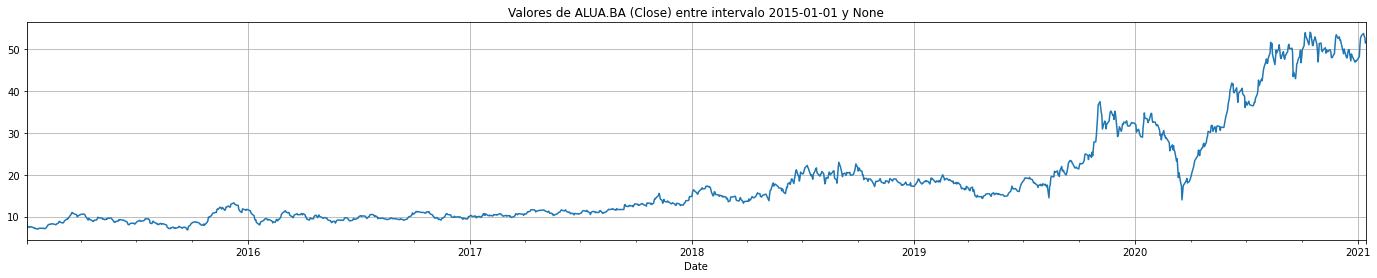

In [7]:
fig,axes = plt.subplots(1,1,figsize=(24,4))
axes.set_title("Valores de %s (%s) entre intervalo %s y %s" % (symbol,series_col,start_date,end_date) )
series.plot(ax=axes,grid=True)
plt.show()

## 2. Separación del Dataset en Entrenamiento y Evaluación

En este punto se establece la separación entre el dataset que se utilizará para análisis y entrenamiento de modelos y el que se reserva para la evaluación del algoritmo. 
Dependiendo del tipo de entrenamiento, la primera partición podrá volver a particionarse, por ejemplo para cross-validation.

In [11]:
def split_dataset(series, horizon):
  total_samples = len(series)
  split_point = total_samples-horizon
  train, test = series[0:split_point], series[split_point:]
  return train, test

Train (2015-12-2020-11-12): 2142 muestras.
Test (2020-1113-2021-1-15): 64 muestras.


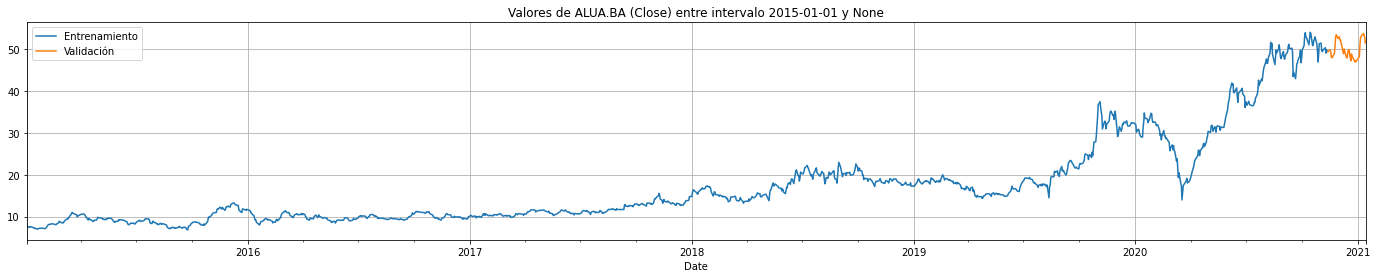

In [12]:
#TRAIN_TEST_SPLIT = 0.7
train,test = split_dataset(series,STEPS_TO_PREDICT)
train_start = "%d-%d%d" % (train.index[0].year,train.index[0].month,train.index[0].day)
train_end = "%d-%d-%d" % (train.index[-1].year,train.index[-1].month,train.index[-1].day)
test_start = "%d-%d%d" % (test.index[0].year,test.index[0].month,test.index[0].day)
test_end = "%d-%d-%d" % (test.index[-1].year,test.index[-1].month,test.index[-1].day)
print("Train (%s-%s): %d muestras." % (train_start, train_end, len(train) ) )
print("Test (%s-%s): %d muestras." % (test_start, test_end, len(test) ) )

fig,axes = plt.subplots(1,1,figsize=(24,4))
axes.set_title("Valores de %s (%s) entre intervalo %s y %s" % (symbol,series_col,start_date,end_date) )
train.plot(ax=axes,grid=True,label="Entrenamiento")
test.plot(ax=axes,grid=True,label="Validación")
axes.legend(["Entrenamiento","Validación"])
plt.show()

Observaciones:
- Existe un cambio significativo en la evolución de las series a partir de la fecha de corte. Parece dificil, utilizando únicamente los valores históricos de la serie univariable obtener un pronóstico acertado.

### 3. Evaluación del Dataset

Cada modelo será evaluado sobre el Test set con las siguientes métricas:

- Mean Square Error ($MSE$): indica que can cercana es la predicción a las observaciones reales mediante el cuadrado de su distancia. Se debe minimizar.
- Mean Absolute Error ($MAE$): promedio de errores en las predicciones.
- Root Mean Square Error ($RMSE$): raíz promedio de la magnitud del error cuadrado.
- Mean Absolute Percentage Error ($MAPE$): mide la exactitud del modelo en términos de porcentaje de error. Es una de las métricas más usadas para series temporales.
- R Squared ($R^2$): determina la proporción de la varianza en la variable dependiente que puede ser explicada por la variable independiente. 

En todos los casos, valores próximos a cero indican un buen desempeño del modelo.

La función *report_model()* calcula estas métricas para el prónostico realizado por cada modelo. Estos resultados luego se almacenanarán en un diccionario.

In [13]:
from sklearn import metrics

def report_model(history,predictions,test,display=True):
  n_history = len(history)
  n_predicted = len(predictions)
  y_true, y_pred = np.array(test), np.array(predictions)  
  mse = metrics.mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
  mae = metrics.mean_absolute_error(y_true, y_pred)
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  r2 = metrics.r2_score(y_true, y_pred)
  
  if display:
    plt.figure(figsize=(24,4))
    plt.title("Predicción para %s (%s) entre intervalo %s y %s" % (symbol,series_col,start_date,
      end_date if end_date else "actualidad") )
    plt.grid(which="Both")
    plt.plot(np.arange(n_history),history)
    plt.plot(np.arange(n_history-n_predicted,n_history),predictions)
    plt.legend(["Observación","Predicción"])
    plt.show()
    print( 'MSE: %.3f ' % mse)
    print( 'RMSE: %.3f ' % rmse)
    print( 'MAE: %.3f ' % mae)
    print( 'MAPE: %.3f ' % mape)
    print( 'R2: %.3f ' % r2)

  return mse,rmse,mae,mape,r2

In [14]:
# Para almacenar métricas de fmodelos ensayados
model_metric_results = {}

Ejemplo para modelo de Persistencia, usado como baseline.

In [15]:
def baseline_walk_forward(train,validation):
  x_train_values = train.values.astype( 'float32' )
  x_val_values = validation.values.astype( 'float32' )
  
  history = [x for x in x_train_values]
  predictions = list()

  for i in range(0,len(x_val_values),STEPS_TO_PREDICT):  

    n_steps = min(STEPS_TO_PREDICT,len(x_val_values)-i)

    # predict
    yhat = history[-1]
    for j in range(n_steps):
      predictions.append(yhat)
      
      # observation
      obs = x_val_values[i+j]
      history.append(obs)
  return history, predictions

start_time=timeit.default_timer()
history, predictions = baseline_walk_forward(train,test)
prediction_time = timeit.default_timer()-start_time
training_time = 0

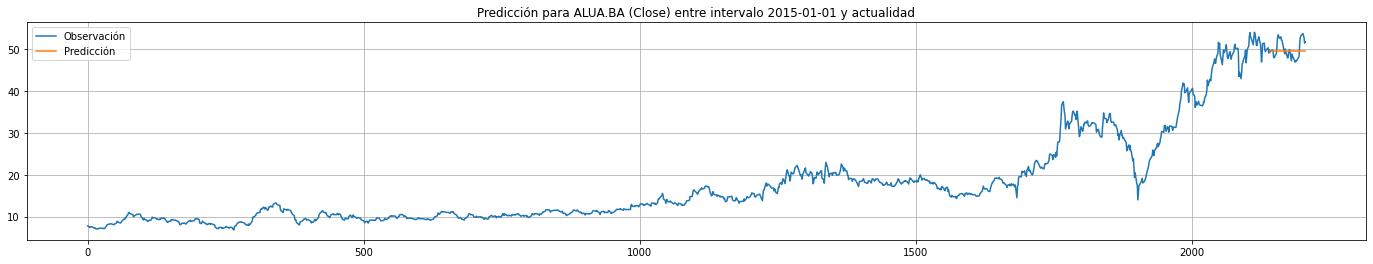

MSE: 4.699 
RMSE: 2.168 
MAE: 1.787 
MAPE: 3.517 
R2: -0.051 


In [16]:
mse,rmse,mae,mape,r2 = report_model(history,predictions,test)

In [17]:
print("Tiempo de Entrenamiento:", training_time)
print("Tiempo de Predicción:", prediction_time)

Tiempo de Entrenamiento: 0
Tiempo de Predicción: 0.0003401989997655619


In [18]:
model_metric_results["baseline"] = {
    "MSE": rmse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Tiempo de Entrenamiento": training_time,
    "Tiempo de Predicción": prediction_time,
    "Descripción": "Modelo de base (Persistencia)"
}

## 4. Análisis Exploratorio de Datos


### Resumen de 5 Números

In [20]:
train.describe()

count    2142.000000
mean       17.307591
std        10.521174
min         6.820000
25%        10.050000
50%        13.606250
75%        19.518750
max        54.099998
Name: Close, dtype: float64

Observaciones:
- TODO

### Gráfico de Tendencia.

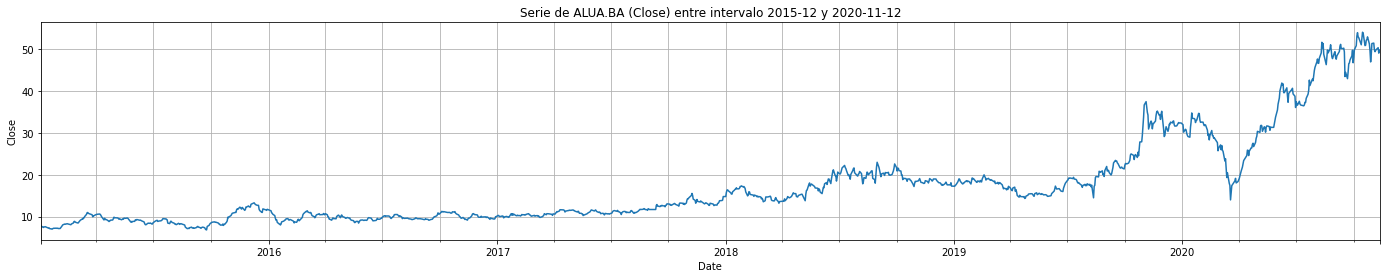

In [21]:
plt.figure(figsize=(24,4))
train.plot()
plt.title("Serie de %s (%s) entre intervalo %s y %s" % (symbol,series_col,train_start,train_end) )
plt.grid(which="Both")
plt.ylabel(series_col)
plt.show()

Observaciones:
- TODO

### Histograma y Estimación de Densidad de Kernel

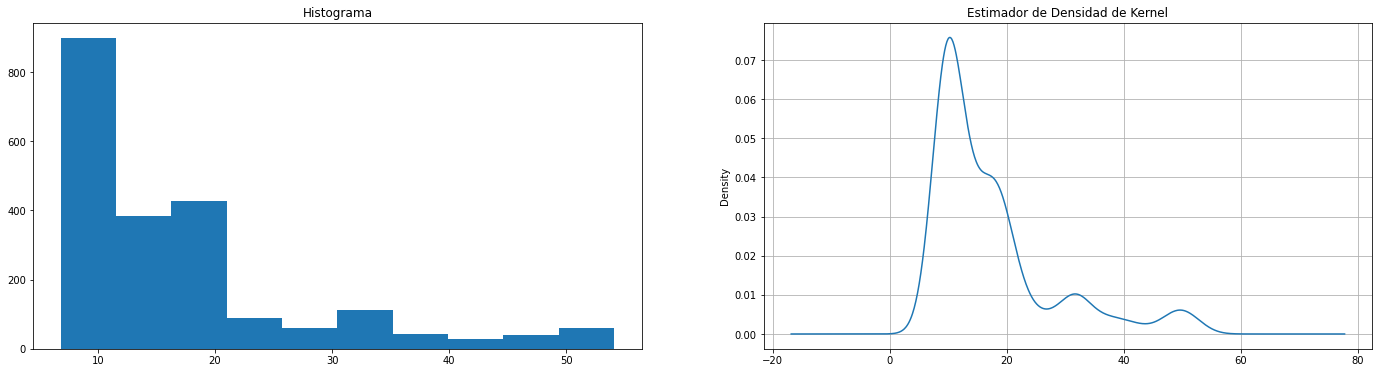

In [22]:
fig,axes = plt.subplots(1,2,figsize=(24,6))
train.hist(ax=axes[0])
axes[0].grid(which='Both')
axes[0].set_title("Histograma")
train.plot(kind='kde',ax=axes[1])
axes[1].grid(which='Both')
axes[1].set_title("Estimador de Densidad de Kernel")
plt.show()

Observaciones:
- Se vé que no es una Gaussiana, por lo que se espera la transformación Box-Cox mejore el desempeño de los algoritmos de la familia SARIMA.

### Diagrama de Box y Whisker

Se agrupan las muestras de a 120 días y se obtienen 60 muestras aleatorias de cada grupo con reemplazo. 

Nota: esto es porque el primer y último grupo no tienen la misma cantidad de muestras.

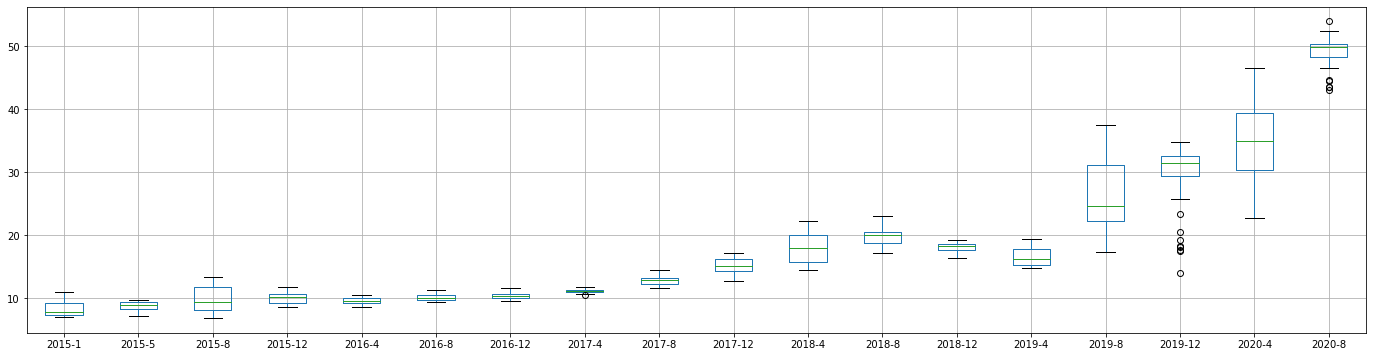

In [23]:
periods = pd.DataFrame()
for name,group in train.groupby(pd.Grouper(freq= '120D')):
  period_name = str(name.year)+"-"+str(name.month)
  periods[period_name] = group.sample(60,replace=True).values
fig,axes = plt.subplots(figsize=(24,6))
periods.boxplot(ax=axes)

Observaciones:
- Se vé una tendencia ascendente, probablemente no lineal. Esto sugiere la necesidad de una diferenciación previa de los datos para usar en los modelos de la familia SARIMA.

### Descomposición Estructural

Una abstracción útil para realizar una mejor selección de parámetros y preparación de los datos para los algoritmos predictivos es descomponer una serie en componentes sistemáticos que puedan ser representados por modelos matemáticos.
Estos componentes pueden ser:
- **Nivel**: el nivel o valor promedio de la serie.
- **Tendencia**: el incremento o decremento sistemático.
- **Estacionalidad**: la repetición de ciclos de corta duración en las series.
- **Ruido**: cambios aleatorios que no pueden ser modelados.

Se estudia la descomposición utilizando la función *seasonal_decompose()* de [statmodels](https://www.statsmodels.org/). 
Internamente, es implementada por la librería con el filtro [Prescott-Hodrick](
https://en.wikipedia.org/wiki/Hodrick%E2%80%93Prescott_filter). Es importante tener presente algunas limitaciones de de este algoritmo (COMPLETAR).



In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_decomposition(result):
  fig,axes = plt.subplots(4,1,figsize=(24,14))
  fig.suptitle("Descomposición de Serie de %s (%s) entre intervalo %s y %s" % (symbol,series_col,train_start,train_end) )
  axes[0].grid(which='Both')
  axes[0].set_title("Observación")
  result.observed.plot(ax=axes[0])
  axes[1].grid(which='Both')
  axes[1].set_title("Tendencia")
  result.trend.plot(ax=axes[1])
  axes[2].grid(which='Both')
  axes[2].set_title("Estacionalidad")
  result.seasonal.plot(ax=axes[2])
  axes[3].grid(which='Both')
  axes[3].set_title("Residual")
  result.resid.plot(ax=axes[3])
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])

#### Descomposición Aditiva

$
y(t) = Level + Trend + Seasonality + Noise
$

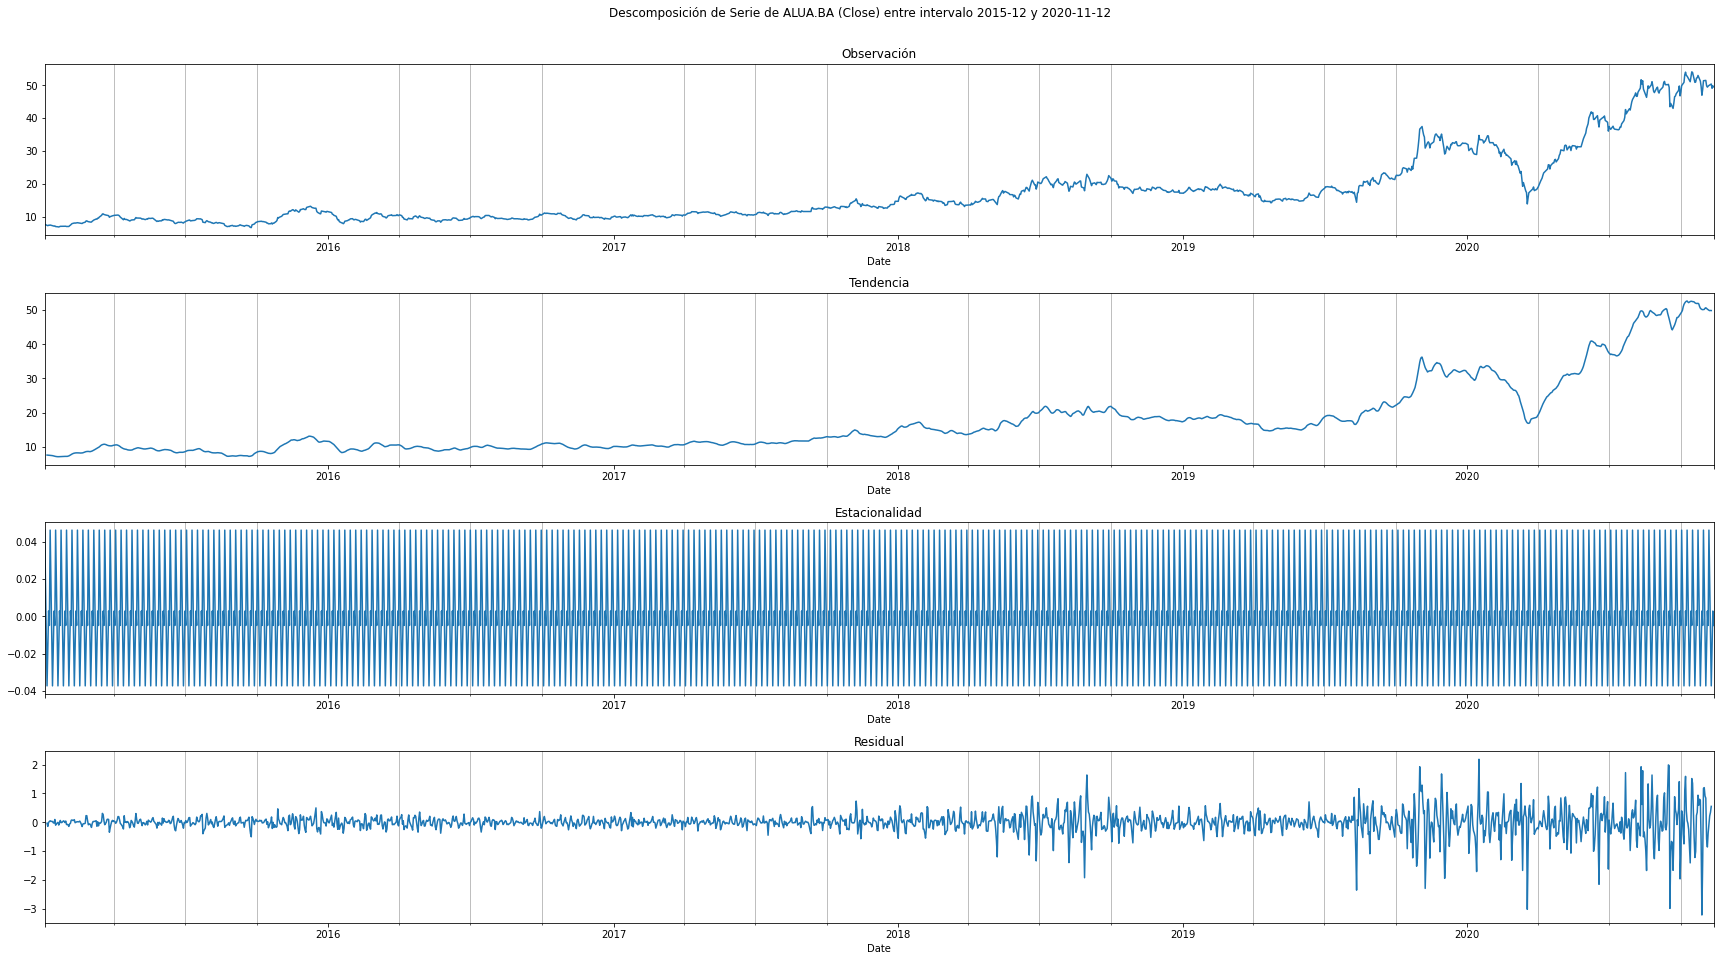

In [26]:
result = seasonal_decompose(train, model='additive' )
plot_decomposition(result)

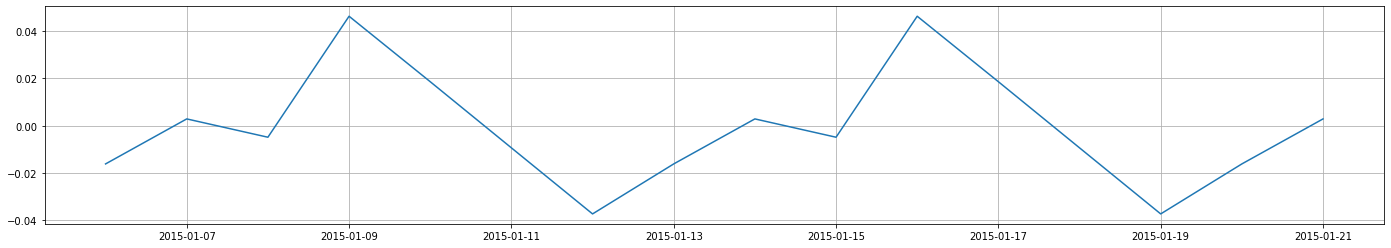

In [27]:
fig,axes = plt.subplots(1,figsize=(24,4))
axes.grid(which="Both")
axes.plot(result.seasonal[4:20])

#### Descomposición Multiplicativa

$
y(t)=Level \times Trend \times Seasonality \times Noise
$

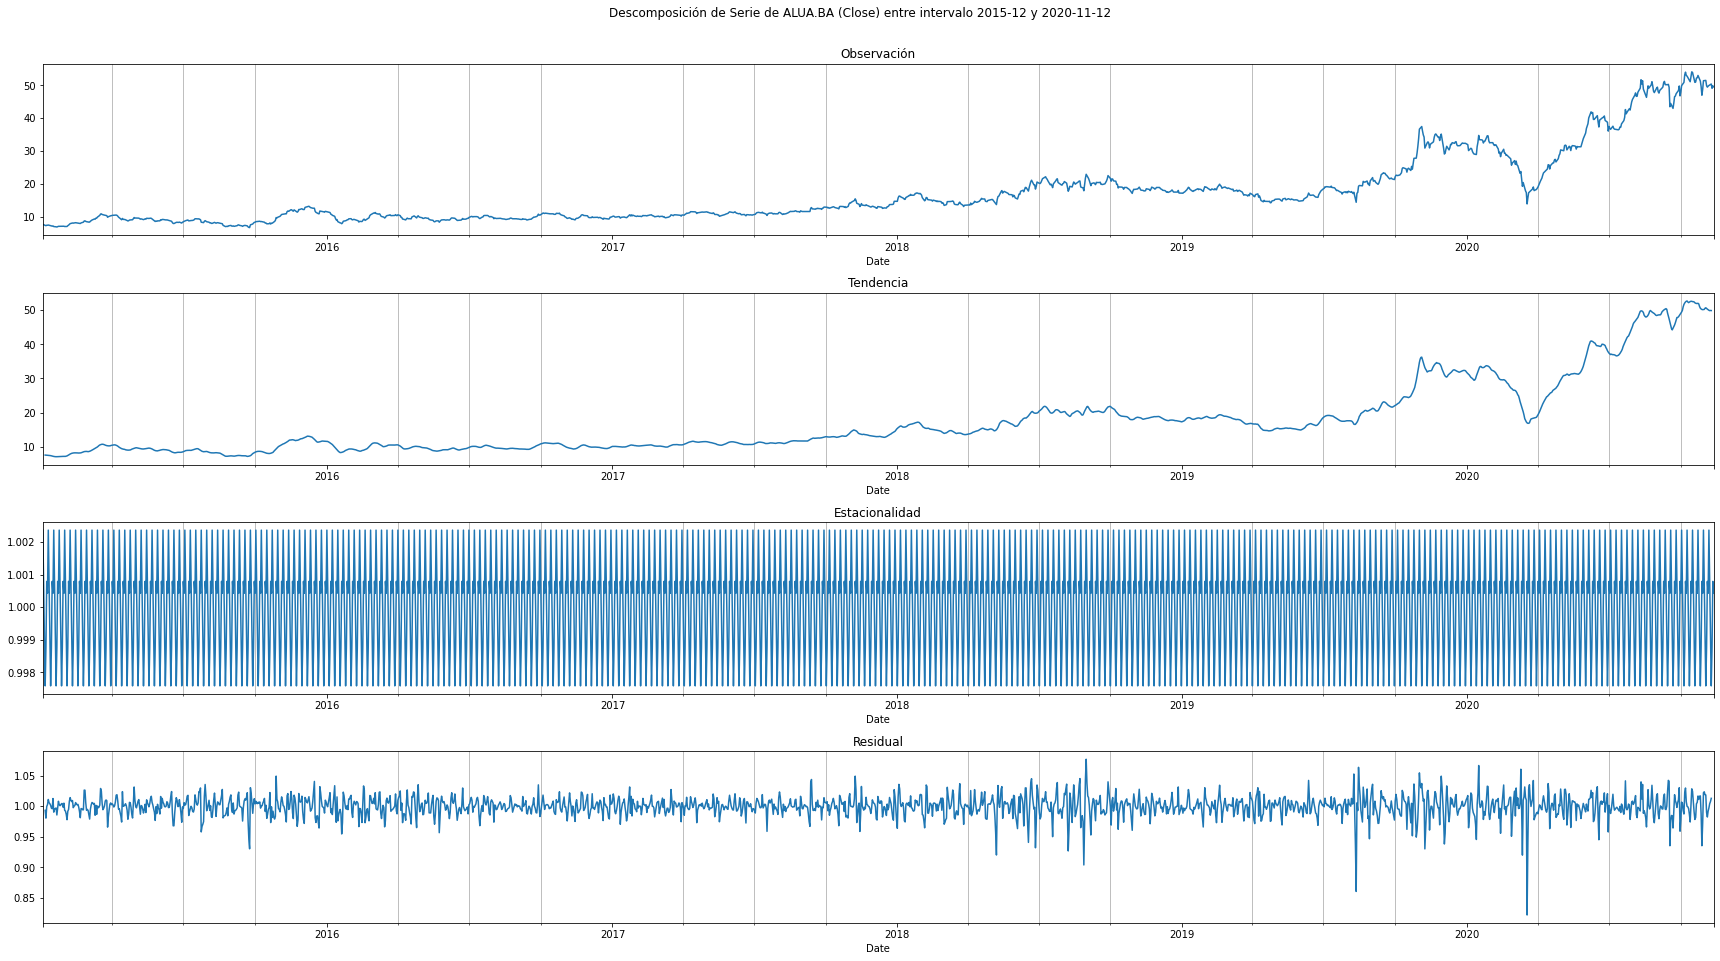

In [28]:
result = seasonal_decompose(train, model='multiplicative' )
plot_decomposition(result)

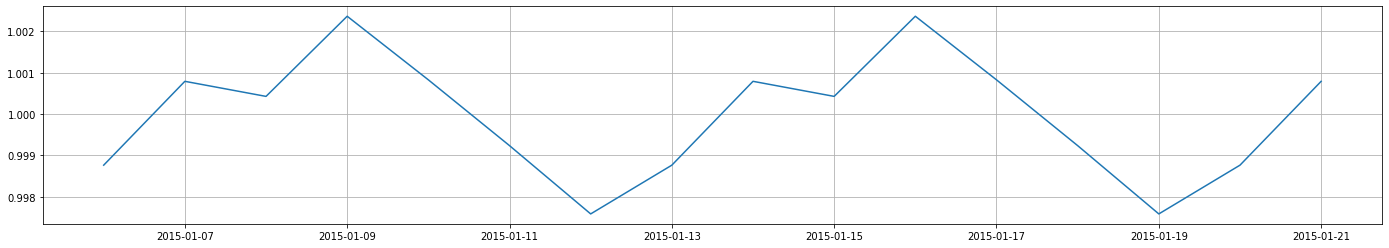

In [29]:
fig,axes = plt.subplots(1,figsize=(24,4))
axes.grid(which="Both")
axes.plot(result.seasonal[4:20])

### Tests de Hipótesis y Transformaciones requeridas



Algunos modelos, como por ejemplo los de la familia SARIMA, requieren que una serie sea estacionaria. Para verificar si la serie es estacionaria se puede realizar el test de Dickey-Fuller Aumentado.

In [30]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(data):
  # check if stationary
  result = adfuller(data)
  print( 'ADF Statistic: %f' % result[0])
  print( 'p-value: %f' % result[1])
  print( 'Critical Values:'  )
  for key, value in result[4].items():
    print( '\t%s: %.3f' % (key, value))

  if result[0] < result[4]['1%']:
    print("Se rechaza H0. La serie es estacionaria.")    
  else:
    print("No se rechaza H0. La serie no es estacionaria.")    

In [31]:
test_stationarity(train)

ADF Statistic: 0.724880
p-value: 0.990322
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
No se rechaza H0. La serie no es estacionaria.


En caso de que no lo sea, se deben realizar las transformaciones para convertir a una serie estacionaria.

De acuerdo a lo observado en los gráficos anteriores, se observa en la serie:
- **Tendencia**: se evidencia una tendencia creciente que parece poder aproximarse a un modelo lineal.
- **Estacionalidad**: se observa un ciclo de aproximadamente 7 días. De todos modos, no parece ser muy significativo.

Una forma de hacer la serie estacionaria es aplicar una diferencia.

In [32]:
def difference(dataset):
  diff = list()
  for i in range(1, len(dataset)):
    value = dataset[i] - dataset[i - 1]
    diff.append(value)
  return pd.Series(diff)

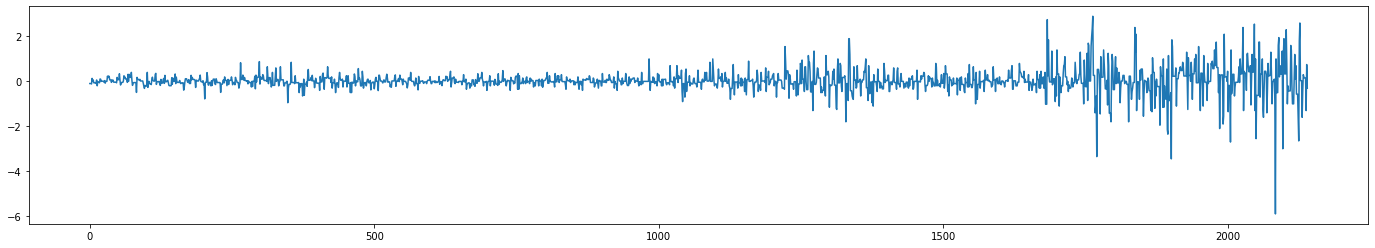

In [33]:
train_diff = difference(train)
plt.figure(figsize=(24,4))
plt.plot(train_diff)

In [34]:
test_stationarity(train_diff)

ADF Statistic: -12.820297
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Se rechaza H0. La serie es estacionaria.


Rechazar la Hipótesis Nula significa con un nivel de significancia menor al 1% implica que el proceso no tiene raíz unitaria, y por lo tanto la serie es estacionaria y no tiene una estructura dependiente del tiempo.

## Entrenamiento de Modelos

### Modelos con Suavizado Exponencial 

Para elegir el modelo inicial se siguen las siguientes recomendaciones:
- Si los datos exhiben una tendencia o estacionalidad, se puede usar el suavizado exponencial simple.
- Si hay tendencia sin estacionalidad, suavizado exponencial doble.
- Finalmente si hay tendencia y estacionalidad, suavizado exponencial triple (Holt-Winters).

Por completitud, se ensayarán las tres clases de suavizado, si bien se espera que el primero no funcione. Para los dos últimos tipos se realizará una búsqueda de parámetros por grilla.

In [47]:
warnings.filterwarnings("ignore") # Para filtrar FutureWarnings de cambio de API

#### Suavizado Exponencial Simple

$
y(t) = \alpha y(t) + (1-\alpha)y(t-1), 0\le \alpha \le 1
$

In [48]:
from statsmodels.tsa.api import SimpleExpSmoothing

In [49]:
 def predict_with_ses(train,validation):
  x_train_values = train.values.astype( 'float32' )
  x_val_values = validation.values.astype( 'float32' )
  
  history = [x for x in x_train_values]
  predictions = list()

  for i in range(0,len(x_val_values),STEPS_TO_PREDICT):

    n_steps = min(STEPS_TO_PREDICT,len(x_val_values)-i)

    # predict    
    model = SimpleExpSmoothing(np.asarray(history))
    model = model.fit(optimized= True, use_brute = True)
    yhat = model.forecast(n_steps)
    for j in range(n_steps):
      predictions.append(yhat[j])      
      # observation
      obs = x_val_values[i+j]
      history.append(obs)

  return history, predictions,model

In [50]:
training_time = 0
start_time=timeit.default_timer()
history, predictions,model = predict_with_ses(train,test)
prediction_time = timeit.default_timer()-start_time

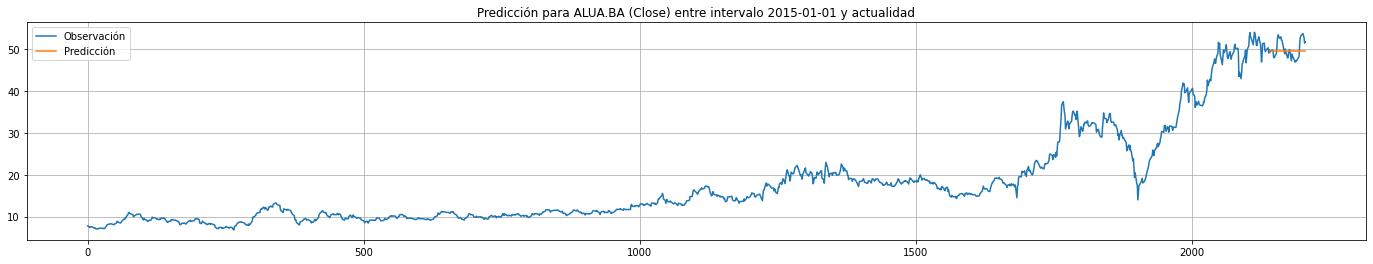

MSE: 4.699 
RMSE: 2.168 
MAE: 1.787 
MAPE: 3.517 
R2: -0.051 


In [51]:
mse,rmse,mae,mape,r2 = report_model(history,predictions,test)

In [52]:
model.summary()

Dep. Variable:,endog,No. Observations:,2142
Model:,SimpleExpSmoothing,SSE,509.098
Optimized:,True,AIC,-3073.743
Trend:,None,BIC,-3062.404
Seasonal:,None,AICC,-3073.725
Seasonal Periods:,None,Date:,"Sun, 17 Jan 2021"
Box-Cox:,False,Time:,13:59:52
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
initial_level,7.8035848,l.0,True


Observaciones:
- Se comprueba que el modelo no funciona bien sobre una serie tiene tendencia y estacionalidad. Se continuará ensayando los siguientes tipos de suavizado.

In [41]:
print("Tiempo de Entrenamiento:", training_time)
print("Tiempo de Predicción:", prediction_time)

Tiempo de Entrenamiento: 0
Tiempo de Predicción: 0.01960966099977668


In [42]:
model_metric_results["SES"] = {
    "MSE": rmse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Tiempo de Entrenamiento": training_time,
    "Tiempo de Predicción": prediction_time,
    "Descripción": "Suavizado Exponencial Simple"
}
model_metric_results["SES"]

#### Suavizado Exponencial Doble (Holt)

In [53]:
from statsmodels.tsa.api import Holt

In [54]:
def predict_with_holt(train,validation,params):
  x_train_values = train.values.astype( 'float32' )
  x_val_values = validation.values.astype( 'float32' )
  
  history = [x for x in x_train_values]
  predictions = list()

  for i in range(0,len(x_val_values),STEPS_TO_PREDICT):

    n_steps = min(STEPS_TO_PREDICT,len(x_val_values)-i)

    # predict    
    model = Holt(np.asarray(history),
                 damped_trend=params["damped_trend"])
    model = model.fit(
        smoothing_level=params["smoothing_level"],
        smoothing_trend=params["smoothing_trend"],
        damping_trend = params["damping_trend"],
        optimized=False
    )
    yhat = model.forecast(n_steps)
    for j in range(n_steps):
      predictions.append(yhat[j])      
      # observation
      obs = x_val_values[i+j]
      history.append(obs)

  return history, predictions,model

In [66]:
from sklearn.model_selection import ParameterGrid

param_grid = { 
    'smoothing_level': [0.10, .50,.60,.90], 
    'smoothing_trend': [.30,.70,.80,.90],
    'damping_trend': [0.10, .60,.80,.90],
    'damped_trend' : [True, False]
}
pg = ParameterGrid(param_grid)
bar = tqdm(total=len(pg))
pg = list(pg)

df_results_moni = pd.DataFrame(columns=[k for k in param_grid.keys()])

x_train,x_val = split_dataset(train,int(len(train)*0.7))

start_time = timeit.default_timer()
for a,b in enumerate(pg):
    params = {
        "smoothing_level": b.get('smoothing_level'),
        "smoothing_trend": b.get('smoothing_trend'),
        "damping_trend": b.get('damping_trend'),
        "damped_trend": b.get('damped_trend')
    }
    history,predictions,model = predict_with_holt(x_train,x_val,params)
    mse,rmse,mae,mape,r2 = report_model(history,predictions,x_val,display=False)
    df_results_moni = df_results_moni.append(
        {
            'smoothing_level': params['smoothing_level'], 
            'smoothing_trend': params['smoothing_trend'],
            'damping_trend': params['damping_trend'],
            'damped_trend': params['damped_trend'],
            'RMSE': rmse,
            'r2': r2,
            'MAE': mae,
            'MAPE': mape,
            'MSE': mse
         }, ignore_index=True)
    bar.update(1)
training_time = timeit.default_timer()-start_time

In [67]:
df_results_moni.sort_values("RMSE",ascending=True).head(5)

,smoothing_level,smoothing_trend,damping_trend,damped_trend,MAE,MAPE,MSE,RMSE,r2
31,0.9,0.9,0.6,True,2.257261,9.767370,14.838450,3.852071,0.875517
30,0.9,0.8,0.6,True,2.257040,9.777960,14.865330,3.855558,0.875292
36,0.5,0.3,0.8,True,2.303155,10.035105,14.881406,3.857642,0.875157
29,0.9,0.7,0.6,True,2.256513,9.787061,14.893010,3.859146,0.875060
40,0.6,0.3,0.8,True,2.313318,10.070461,14.942469,3.865549,0.874645


In [68]:
best_params = df_results_moni.sort_values("RMSE",ascending=True).iloc[0]

In [69]:
prediction_time = timeit.default_timer()
history,predictions,model = predict_with_holt(train,test,best_params)
prediction_time = timeit.default_timer()-start_time

In [70]:
model.summary()

Dep. Variable:,endog,No. Observations:,2142
Model:,Holt,SSE,543.069
Optimized:,False,AIC,-2929.379
Trend:,Additive,BIC,-2901.031
Seasonal:,None,AICC,-2929.326
Seasonal Periods:,None,Date:,"Sun, 17 Jan 2021"
Box-Cox:,False,Time:,14:06:28
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9000000,alpha,False
smoothing_trend,0.9000000,beta,False


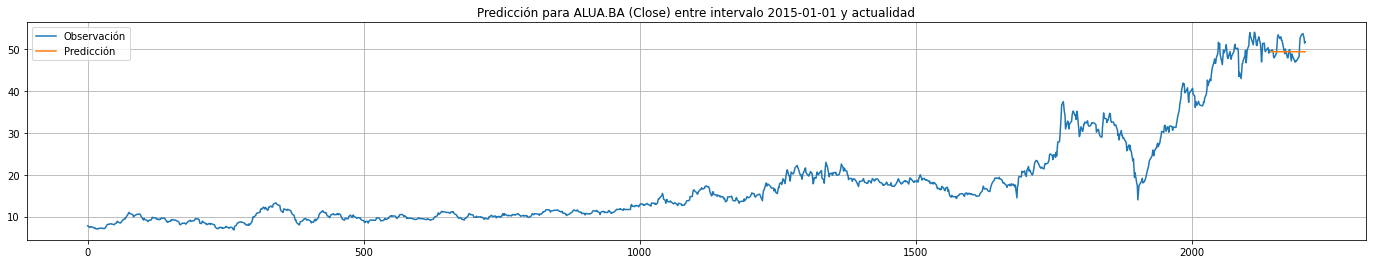

MSE: 4.816 
RMSE: 2.194 
MAE: 1.787 
MAPE: 3.509 
R2: -0.077 


In [72]:
mse,rmse,mae,mape,r2 = report_model(history,predictions,test,display=True)

In [73]:
print("Tiempo de Entrenamiento:", training_time)
print("Tiempo de Predicción:", prediction_time)

Tiempo de Entrenamiento: 92.58281877700028
Tiempo de Predicción: 0.22256200599986187


In [74]:
model_metric_results["Holt"] = {
    "MSE": rmse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Tiempo de Entrenamiento": training_time,
    "Tiempo de Predicción": prediction_time,
    "Descripción": "Suavizado Exponencial Doble (Holt)"
}
model_metric_results["Holt"]

#### Suavizado Exponencial Triple (Holt-Winters)

Pronóstico (aditivo):

$$
F_{t+k} = L_t + kT_t + S_{t+k-M}
$$

Pronóstico (multiplicativo)

$$
F_{t+k} = (L_t+kT_t) S_{t+k-M}
$$

Nivel:

$$
L_t = \alpha(\frac{y_t}{S_{t-M}}+(1-\alpha)(L_{t-1}+T_{T-1})
$$

Tendencia (aditiva):

$$
T_t = \beta(L_t-L_{t-1}) + (1-\beta)T_{t-1}
$$

Estacionalidad (multiplicativa):

$$
S_t = \gamma(Y_t-L_t)+(1+\gamma)S_{t-M}
$$

Siendo $\alpha$, $\beta$, $\gamma$ los parámetros de suavizado.

In [75]:
from statsmodels.tsa.api import ExponentialSmoothing

def predict_with_holtwinters(train,validation,params):
  x_train_values = train.values.astype( 'float32' )
  x_val_values = validation.values.astype( 'float32' )
  
  history = [x for x in x_train_values]
  predictions = list()

  for i in range(0,len(x_val_values),STEPS_TO_PREDICT):

    n_steps = min(STEPS_TO_PREDICT,len(x_val_values)-i)

    # predict    
    model = ExponentialSmoothing(np.asarray(history),
                trend=params["trend"], damped=params["damped"],
                seasonal_periods=params["seasonal_periods"])
    model = model.fit(smoothing_level=params["smoothing_level"],
            smoothing_slope=params["smoothing_slope"],
            damping_slope = params["damping_slope"],
            use_boxcox=params["use_boxcox"],
            optimized=False)
    
    yhat = model.forecast(n_steps)
    for j in range(n_steps):
      predictions.append(yhat[j])      
      # observation
      obs = x_val_values[i+j]
      history.append(obs)

  return history, predictions,model

In [76]:
param_grid = {
    'trend': ['add', 'mul'],
    'seasonal' :['add','mul'],
    'seasonal_periods':[3,5,7], 
    'smoothing_level': [0.10,.50,.90], 
    'smoothing_slope':[0.10,.50,.90],
    'damping_slope': [0.10, 0.20,.90],
    'damped' : [True, False], 
    'use_boxcox':[True, False],
    'remove_bias':[True, False],
    'use_basinhopping':[True, False]
}
pg = ParameterGrid(param_grid)
bar = tqdm(total=len(pg))
pg = list(pg)

df_results_moni = pd.DataFrame(columns=[k for k in param_grid.keys()])

x_train,x_val = split_dataset(train,int(len(train)*0.7))

start_time = timeit.default_timer()
for a,b in enumerate(pg):
    params = { k:b.get(k) for k in param_grid }
    history,predictions,model = predict_with_holtwinters(x_train,x_val,params)
    try:
      mse,rmse,mae,mape,r2 = report_model(history,predictions,x_val,display=False)
      df_results_moni = df_results_moni.append(
          {
              **{ k:params[k] for k in param_grid },
              'RMSE': rmse,
              'r2': r2,
              'MAE': mae,
              'MAPE': mape,
              'MSE': mse
          }, ignore_index=True)
    except ValueError:
      pass
    bar.update(1)
training_time = timeit.default_timer()-start_time

In [77]:
df_results_moni.sort_values("RMSE",ascending=True).head(5)

,trend,seasonal,seasonal_periods,smoothing_level,smoothing_slope,damping_slope,damped,use_boxcox,remove_bias,use_basinhopping,MAE,MAPE,MSE,RMSE,r2
1852,mul,add,5,0.9,0.1,0.9,True,True,True,True,2.356276,10.217157,15.038198,3.877911,0.873842
2284,mul,add,5,0.9,0.1,0.9,True,True,False,True,2.356276,10.217157,15.038198,3.877911,0.873842
2214,mul,add,3,0.9,0.1,0.9,True,True,False,False,2.356276,10.217157,15.038198,3.877911,0.873842
2212,mul,add,3,0.9,0.1,0.9,True,True,False,True,2.356276,10.217157,15.038198,3.877911,0.873842
2142,mul,mul,7,0.9,0.1,0.9,True,True,True,False,2.356276,10.217157,15.038198,3.877911,0.873842


In [84]:
prediction_time = timeit.default_timer()
history,predictions,model = predict_with_holt(train,test,best_params)
prediction_time = timeit.default_timer()-start_time

In [85]:
model.summary()

Dep. Variable:,endog,No. Observations:,2142
Model:,Holt,SSE,543.069
Optimized:,False,AIC,-2929.379
Trend:,Additive,BIC,-2901.031
Seasonal:,None,AICC,-2929.326
Seasonal Periods:,None,Date:,"Sun, 17 Jan 2021"
Box-Cox:,False,Time:,16:14:29
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9000000,alpha,False
smoothing_trend,0.9000000,beta,False


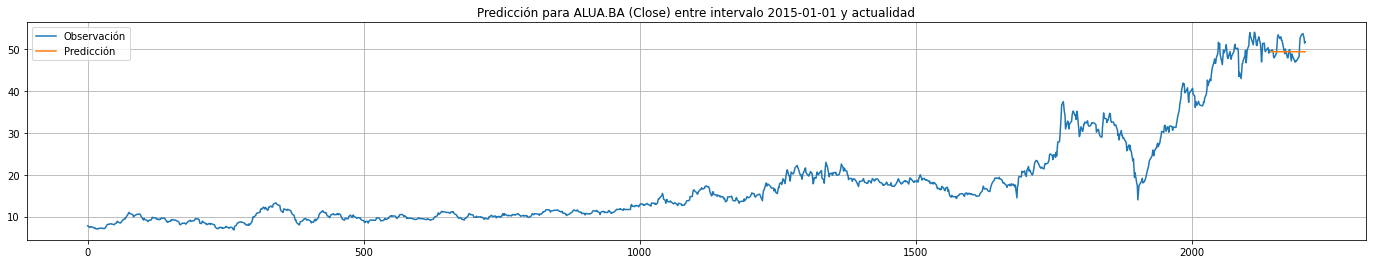

MSE: 4.816 
RMSE: 2.194 
MAE: 1.787 
MAPE: 3.509 
R2: -0.077 


In [86]:
mse,rmse,mae,mape,r2 = report_model(history,predictions,test,display=True)

In [87]:
print("Tiempo de Entrenamiento:", training_time)
print("Tiempo de Predicción:", prediction_time)

Tiempo de Entrenamiento: 4627.33723388
Tiempo de Predicción: 7529.380115609001


In [88]:
model_metric_results["Holt-Winters"] = {
    "MSE": rmse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Tiempo de Entrenamiento": training_time,
    "Tiempo de Predicción": prediction_time,
    "Descripción": "Suavizado Exponencial Triple (Holt-Winters)"
}
model_metric_results["Holt-Winters"]

{'Descripción': 'Suavizado Exponencial Triple (Holt-Winters)',
 'MAE': 1.7872458874994326,
 'MAPE': 3.5093077086814475,
 'MSE': 2.194472355941893,
 'R2': -0.07695594792079152,
 'RMSE': 2.194472355941893,
 'Tiempo de Entrenamiento': 4627.33723388,
 'Tiempo de Predicción': 7529.380115609001}

### Modelos con métodos autoregresivos (SARIMA y otros)

- ARMA
- MA
- ARIMA
- SARIMA
- SARIMAX
- VAR
- VARMA

In [83]:
from pmdarima import auto_arima

In [ ]:
#FIXME

#### ARIMA con Selección Manual de Parámetros

El próximo paso es seleccionar los valores de lag para Autoregresión (AR) y Promedio Móvil (MA), parámetros p y q respectivamente.
Un método es estudiando los gráficos de las funciones de Autocorrelación (ACF) y Autocorrelación Parcial (PACF).

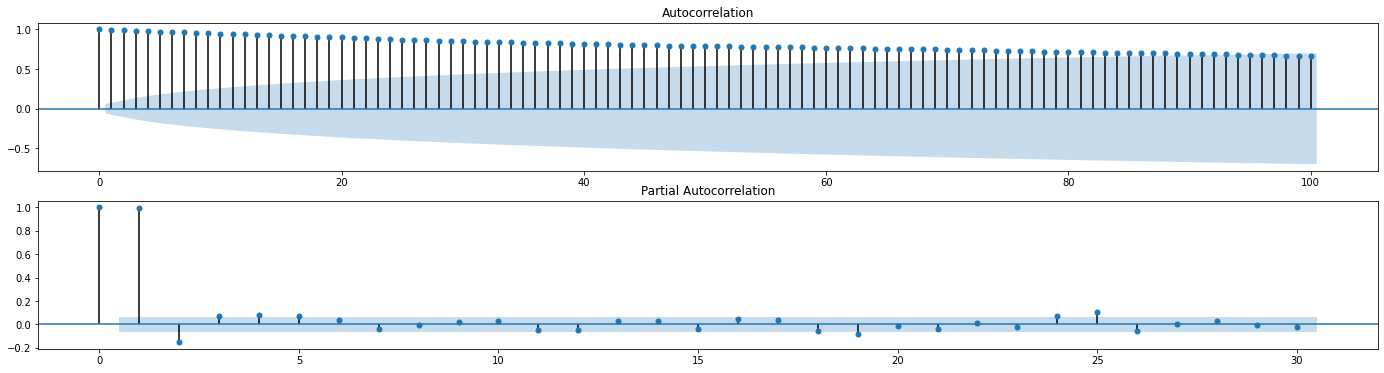

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig,axes = plt.subplots(2,1,figsize=(24,6))
plot_acf(train, lags=100, ax=axes[0])
plot_pacf(train, lags=30, ax=axes[1])
plt.show()

- El gráfico de ACF muestra lags significativos hasta órdenes muy altos, cercanos a 80.
- El gráfico de PACF muestra lags significativos hasta el 1.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from tqdm.notebook import tqdm

def arima_walk_forward(train,validation,p,d,q):
  x_train_values = train.values.astype( 'float32' )
  x_val_values = validation.values.astype( 'float32' )
  
  history = [x for x in x_train_values]
  predictions = list()

  bar = tqdm(total=len(x_val_values))

  for i in range(0,len(x_val_values),STEPS_TO_PREDICT):

    n_steps = min(STEPS_TO_PREDICT,len(x_val_values)-i)

    # predict    
    model = ARIMA(history, order=(p,d,q))
    model = model.fit(disp=0)
    yhat = model.forecast(n_steps)[0]
    for j in range(n_steps):
      predictions.append(yhat[j])      
      # observation
      obs = x_val_values[i+j]
      history.append(obs)
    bar.update(n_steps)

  return history, predictions

Se entrenará un modelo sobre una partición del set de entrenamiento.

In [ ]:
x_train,x_val = split_dataset(train,0.8)

Uno de los problemas de ARIMA es que el entrenamiento es lento para órdenes altos, por lo tanto, se intentará con valores inferiores a 10 para tener tiempos de entrenamiento aceptables.

In [ ]:
p = 10
d = 1
q = 1
history, predictions = arima_walk_forward(x_train,x_val,p,d,q)

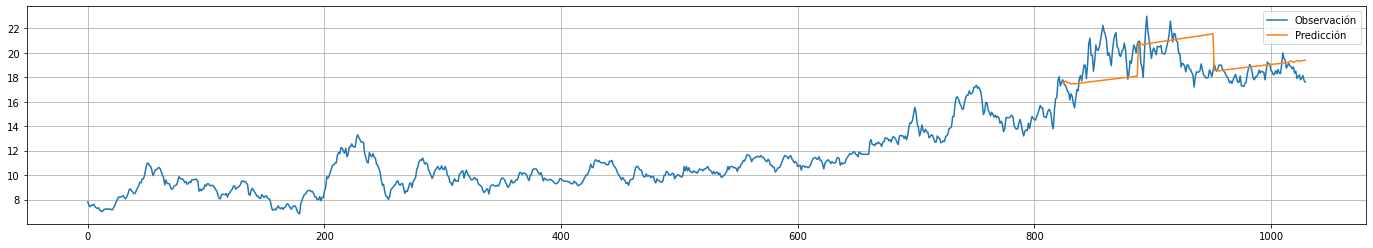

MSE: 3.073 
RMSE: 1.753 
MAE: 1.376 
MAPE: 7.190 
R2: -0.665 


In [ ]:
mse,rmse,mae,mape,r2 = report_model(history,predictions,x_val)

#### Análisis de Residuales

In [ ]:
residuals = [x_val[i]-predictions[i] for i in range(len(x_val))]
residuals = pd.DataFrame(residuals)
residuals.describe()

,0
count,206.000000
mean,-0.210302
std,1.744656
min,-4.127633
25%,-1.169496
50%,-0.454986
75%,0.562209
max,4.490030


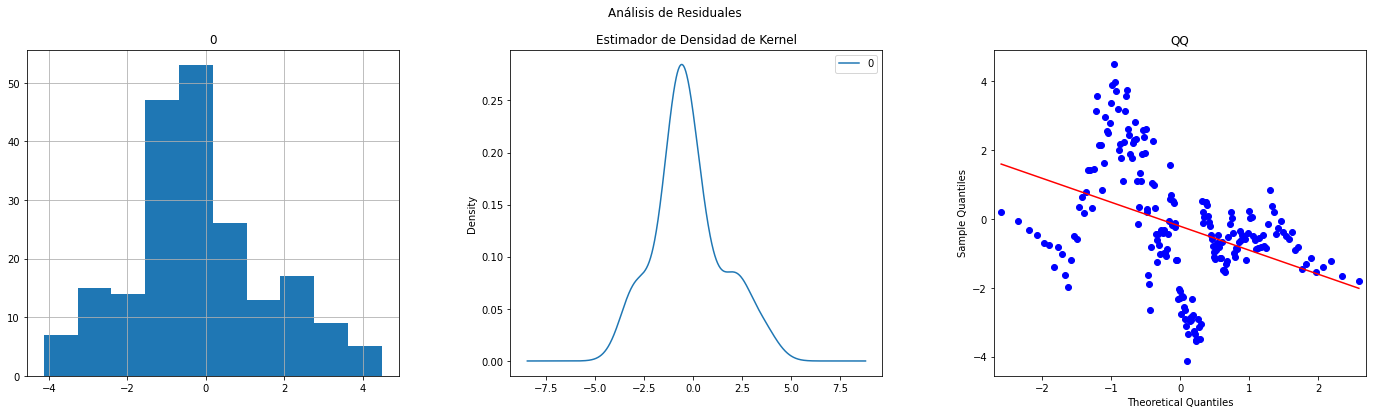

In [ ]:
from statsmodels.graphics.gofplots import qqplot

fig,axes = plt.subplots(1,3,figsize=(24,6))
plt.suptitle("Análisis de Residuales")
axes[0].set_title("Histograma")
residuals.hist(ax=axes[0])
axes[1].set_title("Estimador de Densidad de Kernel")
residuals.plot(kind='kde', ax=axes[1])
axes[2].set_title("QQ")
qqplot(residuals, line= 'r', ax=axes[2] )
plt.show()

Idealmente se espera que los residuales tengan una distribución gaussiana de media cero. No es exactamente una Gaussiana, pero la media es próxima a cero.

- FIXME: ver qué pasa con el QQPlot.

#### Entrenamiento con dataset completo

In [ ]:
start_time=timeit.default_timer()
model = ARIMA(train.values, order=(p,d,q))
model = model.fit(disp=0)
model.save( 'arima.pkl' )
training_time = timeit.default_timer()-start_time

#### Validación contra Test Set

In [ ]:
from statsmodels.tsa.arima_model import ARIMAResults
import numpy

def predict_with_arima(model,train,test,p,q,d):
  bar = tqdm(total=len(test))
  
  history = [x for x in train.values]
  predictions = []
  
  yhat = model.forecast(STEPS_TO_PREDICT)[0]
  for j in range(STEPS_TO_PREDICT):
    predictions.append(yhat[j])

  for i in range(STEPS_TO_PREDICT,len(test),STEPS_TO_PREDICT):
    # predict
    n_steps = min(STEPS_TO_PREDICT,len(test)-i)
    model = ARIMA(history, order=(p,d,q))
    model = model.fit(disp=0)
    yhat = model.forecast(steps=n_steps)[0]
    for j in range(n_steps):
      predictions.append(yhat[j])
      # observation
      obs = test[i+j]
      history.append(obs)
    bar.update(n_steps)
  return history,predictions

In [ ]:
start_time=timeit.default_timer()
model = ARIMAResults.load( 'arima.pkl' )
history,predictions = predict_with_arima(model,train,test,p,q,d)
prediction_time = timeit.default_timer()-start_time

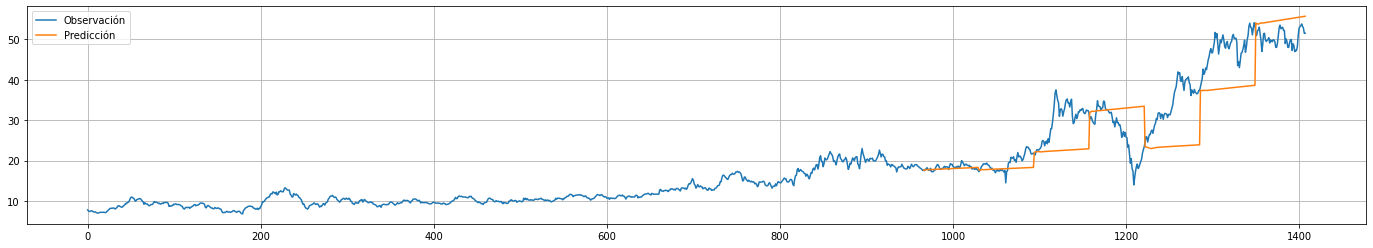

MSE: 60.374 
RMSE: 7.770 
MAE: 6.083 
MAPE: 19.315 
R2: 0.625 


In [ ]:
mse,rmse,mae,mape,r2 = report_model(history,predictions,test)

In [ ]:
print("Tiempo de Entrenamiento:", training_time)
print("Tiempo de Predicción:", prediction_time)

Tiempo de Entrenamiento: 3.3742280550000032
Tiempo de Predicción: 26.851007670999934


In [ ]:
model_metric_results["ARIMA"] = {
    "MSE": rmse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Tiempo de Entrenamiento": training_time,
    "Tiempo de Predicción": prediction_time,
    "Descripción": "ARIMA (p=%d,d=%d,q=%d)" % (p,d,q)
}

### Preparación de Dataset para modelos RNN

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

tf.random.set_seed(42)
np.random.seed(42)

In [174]:
WINDOW_SIZE = 10

In [175]:
train.shape,test.shape

((2142,), (64,))

Feature scaling.

In [176]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train.values.reshape(-1, 1))
#scaled_test = scaler.transform(test.values.reshape(-1, 1))

In [177]:
TRAIN_VAL_SPLIT = 0.6
split_point = int(TRAIN_VAL_SPLIT*len(scaled_train))
ts_train = scaled_train[0:split_point]
ts_val = scaled_train[split_point:]

In [179]:
def prepare_dataset(data,window_size,horizon):
  X,y = [], []
  n = len(data)
  for i in range(n-window_size-horizon):
    X.append(data[i:(i+window_size)])
    y.append(data[(i+window_size):(i+window_size+horizon)])
  return np.array(X), np.array(y)

x_train, y_train = prepare_dataset(ts_train,WINDOW_SIZE,STEPS_TO_PREDICT)
x_val, y_val = prepare_dataset(ts_val,WINDOW_SIZE,STEPS_TO_PREDICT)

x_train.shape,y_train.shape,x_val.shape,y_val.shape

((1211, 10, 1), (1211, 64, 1), (783, 10, 1), (783, 64, 1))

Convertir los datos a tf.data mejora el rendimiento con GPU (ver: [Guide to Data Perfomance in Google Colab](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/data_performance.ipynb)).

In [180]:
BATCH_SIZE = 256
BUFFER_SIZE = 150
train_uv = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_uv = train_uv.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_uv = tf.data.Dataset.from_tensor_slices((x_val,y_val))
val_uv = val_uv.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

### Modelo LSTM

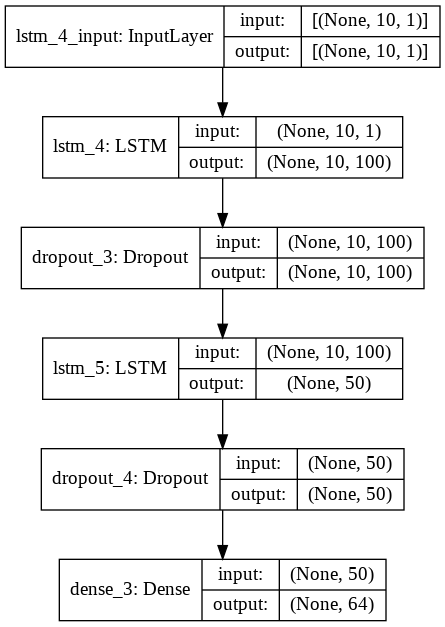

In [181]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, input_shape=x_train.shape[-2:],return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=50,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=STEPS_TO_PREDICT),
])
model.compile(optimizer='adam', loss='mse')
tf.keras.utils.plot_model(model, show_shapes=True)

In [182]:
EVALUATION_INTERVAL = 100
NUM_EPOCHS = 150

start_time=timeit.default_timer()
history = model.fit(
    train_uv, 
    epochs=NUM_EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_uv,
    validation_steps=50,
    verbose =1,
    callbacks =[
      tf.keras.callbacks.EarlyStopping(
          monitor='val_loss', min_delta=0, patience=10,verbose=1, mode='min'),
      tf.keras.callbacks.ModelCheckpoint('lstm_best.h5',
          monitor='val_loss', save_best_only=True, mode='min',verbose=0)
    ])
training_time = timeit.default_timer()-start_time

Epoch 1/150
100/100 [==============================] - 11s 80ms/step - loss: 0.0042 - val_loss: 0.0158
Epoch 2/150
100/100 [==============================] - 7s 70ms/step - loss: 0.0011 - val_loss: 0.0120
Epoch 3/150
100/100 [==============================] - 7s 69ms/step - loss: 9.8509e-04 - val_loss: 0.0118
Epoch 4/150
100/100 [==============================] - 7s 71ms/step - loss: 9.3478e-04 - val_loss: 0.0126
Epoch 5/150
100/100 [==============================] - 7s 71ms/step - loss: 9.0509e-04 - val_loss: 0.0144
Epoch 6/150
100/100 [==============================] - 8s 76ms/step - loss: 8.9086e-04 - val_loss: 0.0154
Epoch 7/150
100/100 [==============================] - 7s 70ms/step - loss: 8.7573e-04 - val_loss: 0.0188
Epoch 8/150
100/100 [==============================] - 7s 70ms/step - loss: 8.6443e-04 - val_loss: 0.0198
Epoch 9/150
100/100 [==============================] - 7s 71ms/step - loss: 8.5885e-04 - val_loss: 0.0207
Epoch 10/150
100/100 [==============================]

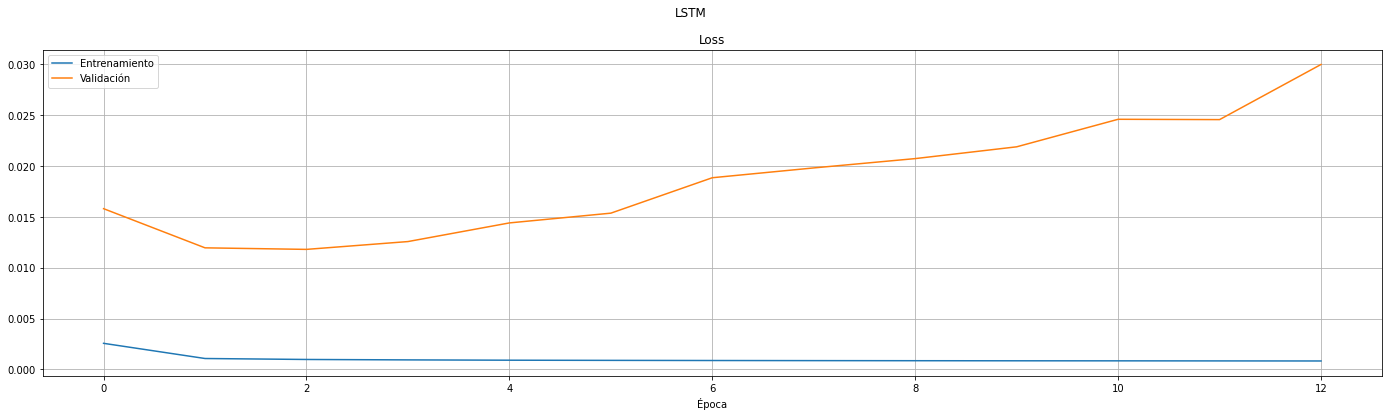

In [183]:
n_trained_epochs = len(history.history['loss'])
fig,axes = plt.subplots(1,1,figsize=(24,6))
plt.suptitle("LSTM")
axes.set_title("Loss")
axes.plot(np.arange(n_trained_epochs),history.history['loss'])
axes.plot(np.arange(n_trained_epochs),history.history['val_loss'])
axes.legend(["Entrenamiento","Validación"])
axes.grid(which="Both")
axes.set_xlabel("Época")
plt.show()

In [184]:
model = tf.keras.models.load_model('lstm_best.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10, 100)           40800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 100)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                3264      
Total params: 74,264
Trainable params: 74,264
Non-trainable params: 0
_________________________________________________________________


In [186]:
def make_single_prediction_with_rnn(model,scaler,input):
  history = [x for x in input.values]
  predictions = []
  input_scaled = scaler.transform(input[-WINDOW_SIZE:].values.reshape(-1, 1))
  yhat = model.predict(input_scaled.reshape(1,WINDOW_SIZE, 1)).T
  yhat = scaler.inverse_transform(yhat).flatten()
  predictions.extend(yhat)
  predictions = np.array(predictions)
  return history,predictions

In [194]:
def report_model2(history,predictions,test,display=True):
  n_history = len(history)
  n_predicted = len(predictions)
  y_true, y_pred = np.array(test), np.array(predictions)  
  mse = metrics.mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
  mae = metrics.mean_absolute_error(y_true, y_pred)
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  r2 = metrics.r2_score(y_true, y_pred)
  
  if display:
    additional_history = 400
    x1 = len(train.values) - WINDOW_SIZE
    x0 = x1 - additional_history
    x2 = len(train.values)
    x3 = len(train.values) + len(test)
    fig,axes = plt.subplots(1,1,figsize=(24,6))
    axes.grid(which='Both')
    axes.plot(np.arange(x0,x1),train.values[x0:x1],color='gray', marker=".")
    axes.plot(np.arange(x1,x2),train.values[x1:x2],color='b', marker=".")
    axes.plot(np.arange(x2,x3),test.values,color='g', marker=".")
    axes.plot(np.arange(x2,x3),predictions,color='r', marker=".")
    axes.legend(["Train","Train/input","Test","Predicción"])
    print( 'MSE: %.3f ' % mse)
    print( 'RMSE: %.3f ' % rmse)
    print( 'MAE: %.3f ' % mae)
    print( 'MAPE: %.3f ' % mape)
    print( 'R2: %.3f ' % r2)

  return mse,rmse,mae,mape,r2


MSE: 23.905 
RMSE: 4.889 
MAE: 4.040 
MAPE: 8.201 
R2: -4.346 


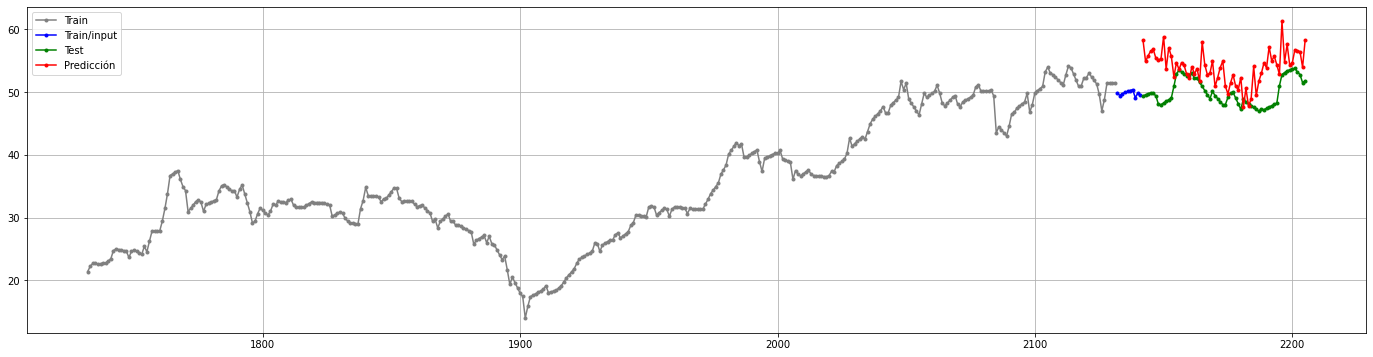

In [195]:
start_time = timeit.default_timer()
model = tf.keras.models.load_model('lstm_best.h5')
history,predictions = make_single_prediction_with_rnn(model,scaler,train)
mse,rmse,mae,mape,r2 = report_model2(history,predictions,test)
prediction_time = timeit.default_timer()-start_time

In [190]:
print("Tiempo de Entrenamiento:", training_time)
print("Tiempo de Predicción:", prediction_time)

Tiempo de Entrenamiento: 96.41565321700182
Tiempo de Predicción: 1.3650628780014813


In [196]:
model_metric_results["LSTM"] = {
    "MSE": rmse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Tiempo de Entrenamiento": training_time,
    "Tiempo de Predicción": prediction_time,
    "Descripción": "LSTM (sin reentrenar)"
}
model_metric_results["LSTM"]

{'Descripción': 'LSTM (sin reentrenar)',
 'MAE': 4.0402589299621585,
 'MAPE': 8.200584625030979,
 'MSE': 4.889266780762317,
 'R2': -4.345953544388812,
 'RMSE': 4.889266780762317,
 'Tiempo de Entrenamiento': 96.41565321700182,
 'Tiempo de Predicción': 1.3600251149982796}

### Modelo LSTM Bidireccional

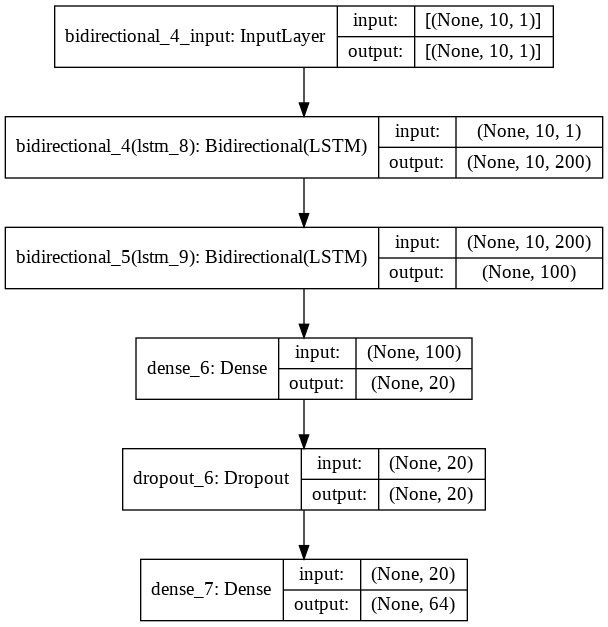

In [198]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(
      tf.keras.layers.LSTM(100,return_sequences=True),input_shape=x_train.shape[-2:]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(20, activation='softmax'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=STEPS_TO_PREDICT),
])

model.compile(optimizer='adam', loss='mse')
tf.keras.utils.plot_model(model, show_shapes=True)

In [199]:
EVALUATION_INTERVAL = 100
NUM_EPOCHS = 150

start_time=timeit.default_timer()
history = model.fit(
    train_uv, 
    epochs=NUM_EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_uv,
    validation_steps=50,
    verbose =1,
    callbacks =[
      tf.keras.callbacks.EarlyStopping(
          monitor='val_loss', min_delta=0, patience=10,verbose=1, mode='min'),
      tf.keras.callbacks.ModelCheckpoint('lstm_bi_best.h5',
          monitor='val_loss', save_best_only=True, mode='min',verbose=0)
    ])
training_time = timeit.default_timer()-start_time

Epoch 1/150
100/100 [==============================] - 23s 163ms/step - loss: 0.0056 - val_loss: 0.1367
Epoch 2/150
100/100 [==============================] - 14s 139ms/step - loss: 0.0023 - val_loss: 0.1147
Epoch 3/150
100/100 [==============================] - 14s 140ms/step - loss: 0.0014 - val_loss: 0.1032
Epoch 4/150
100/100 [==============================] - 14s 139ms/step - loss: 0.0011 - val_loss: 0.0989
Epoch 5/150
100/100 [==============================] - 14s 139ms/step - loss: 0.0010 - val_loss: 0.0969
Epoch 6/150
100/100 [==============================] - 14s 139ms/step - loss: 9.7728e-04 - val_loss: 0.0960
Epoch 7/150
100/100 [==============================] - 14s 140ms/step - loss: 9.1282e-04 - val_loss: 0.0957
Epoch 8/150
100/100 [==============================] - 19s 188ms/step - loss: 8.4656e-04 - val_loss: 0.0968
Epoch 9/150
100/100 [==============================] - 14s 140ms/step - loss: 8.3179e-04 - val_loss: 0.0969
Epoch 10/150
100/100 [==========================

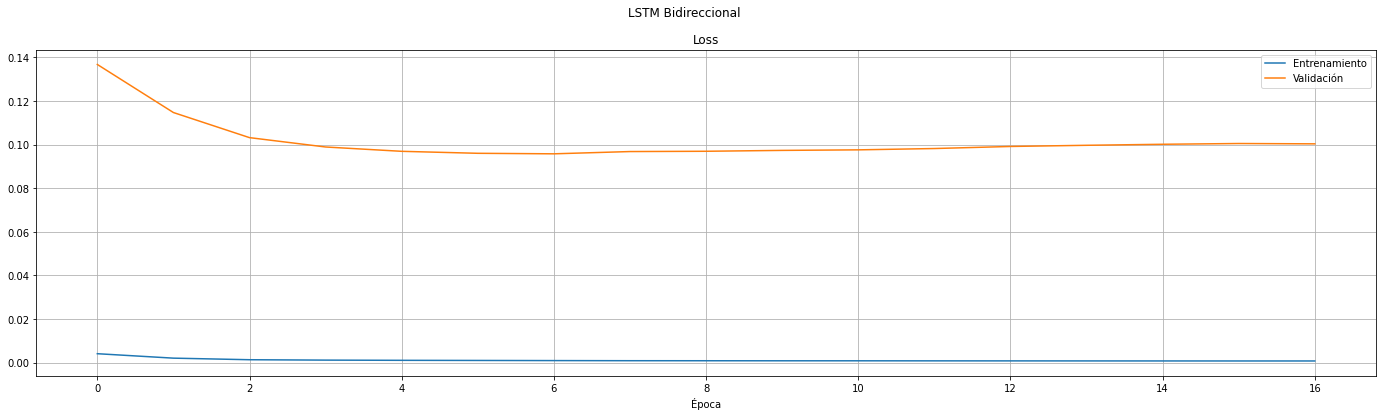

In [200]:
n_trained_epochs = len(history.history['loss'])
fig,axes = plt.subplots(1,1,figsize=(24,6))
plt.suptitle("LSTM Bidireccional")
axes.set_title("Loss")
axes.plot(np.arange(n_trained_epochs),history.history['loss'])
axes.plot(np.arange(n_trained_epochs),history.history['val_loss'])
axes.legend(["Entrenamiento","Validación"])
axes.grid(which="Both")
axes.set_xlabel("Época")
plt.show()

MSE: 1216.382 
RMSE: 34.877 
MAE: 34.814 
MAPE: 69.548 
R2: -271.024 


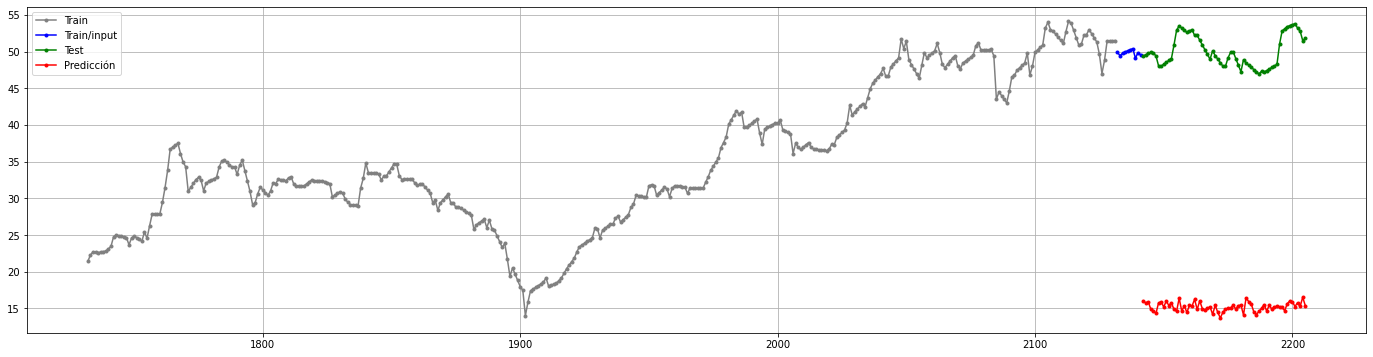

In [202]:
start_time=timeit.default_timer()
model = tf.keras.models.load_model('lstm_bi_best.h5')
history,predictions = make_single_prediction_with_rnn(model,scaler,train)
mse,rmse,mae,mape,r2 = report_model2(history,predictions,test)
prediction_time = timeit.default_timer()-start_time

In [203]:
print("Tiempo de Entrenamiento:", training_time)
print("Tiempo de Predicción:", prediction_time)

Tiempo de Entrenamiento: 251.0666254250027
Tiempo de Predicción: 3.3855442279964336


In [204]:
model_metric_results["LSTM-Bi"] = {
    "MSE": rmse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Tiempo de Entrenamiento": training_time,
    "Tiempo de Predicción": prediction_time,
    "Descripción": "LSTM Bidireccional (sin reentrenar)"
}
model_metric_results["LSTM-Bi"]

{'Descripción': 'LSTM Bidireccional (sin reentrenar)',
 'MAE': 34.81438504664135,
 'MAPE': 69.54754751073654,
 'MSE': 34.876670474346696,
 'R2': -271.0243282443738,
 'RMSE': 34.876670474346696,
 'Tiempo de Entrenamiento': 251.0666254250027,
 'Tiempo de Predicción': 3.3855442279964336}

### Modelo GRU

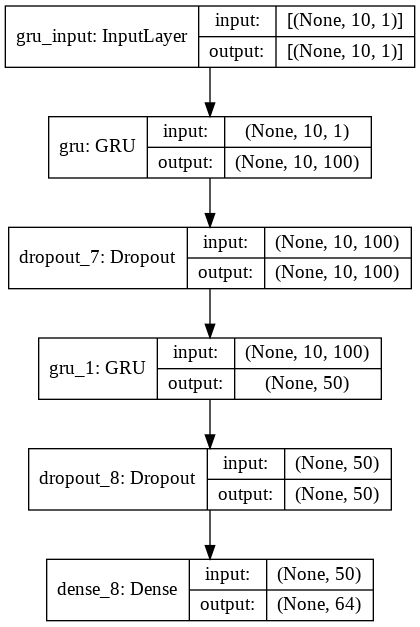

In [205]:
model = tf.keras.models.Sequential([
  tf.keras.layers.GRU(100, input_shape=x_train.shape[-2:],return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(units=50,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=STEPS_TO_PREDICT),
])

model.compile(optimizer='adam', loss='mse')
tf.keras.utils.plot_model(model, show_shapes=True)

In [206]:
EVALUATION_INTERVAL = 100
NUM_EPOCHS = 150

start_time=timeit.default_timer()
history = model.fit(
    train_uv, 
    epochs=NUM_EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_uv,
    validation_steps=50,
    verbose =1,
    callbacks =[
      tf.keras.callbacks.EarlyStopping(
          monitor='val_loss', min_delta=0, patience=10,verbose=1, mode='min'),
      tf.keras.callbacks.ModelCheckpoint('gru_best.h5',
          monitor='val_loss', save_best_only=True, mode='min',verbose=0)
    ])
training_time = timeit.default_timer()-start_time

Epoch 1/150
100/100 [==============================] - 10s 71ms/step - loss: 0.0037 - val_loss: 0.0162
Epoch 2/150
100/100 [==============================] - 6s 62ms/step - loss: 0.0011 - val_loss: 0.0138
Epoch 3/150
100/100 [==============================] - 6s 62ms/step - loss: 9.6752e-04 - val_loss: 0.0125
Epoch 4/150
100/100 [==============================] - 6s 64ms/step - loss: 9.2268e-04 - val_loss: 0.0125
Epoch 5/150
100/100 [==============================] - 6s 64ms/step - loss: 8.8958e-04 - val_loss: 0.0122
Epoch 6/150
100/100 [==============================] - 6s 63ms/step - loss: 8.7183e-04 - val_loss: 0.0121
Epoch 7/150
100/100 [==============================] - 6s 63ms/step - loss: 8.5648e-04 - val_loss: 0.0118
Epoch 8/150
100/100 [==============================] - 6s 63ms/step - loss: 8.4865e-04 - val_loss: 0.0117
Epoch 9/150
100/100 [==============================] - 6s 63ms/step - loss: 8.3979e-04 - val_loss: 0.0116
Epoch 10/150
100/100 [==============================]

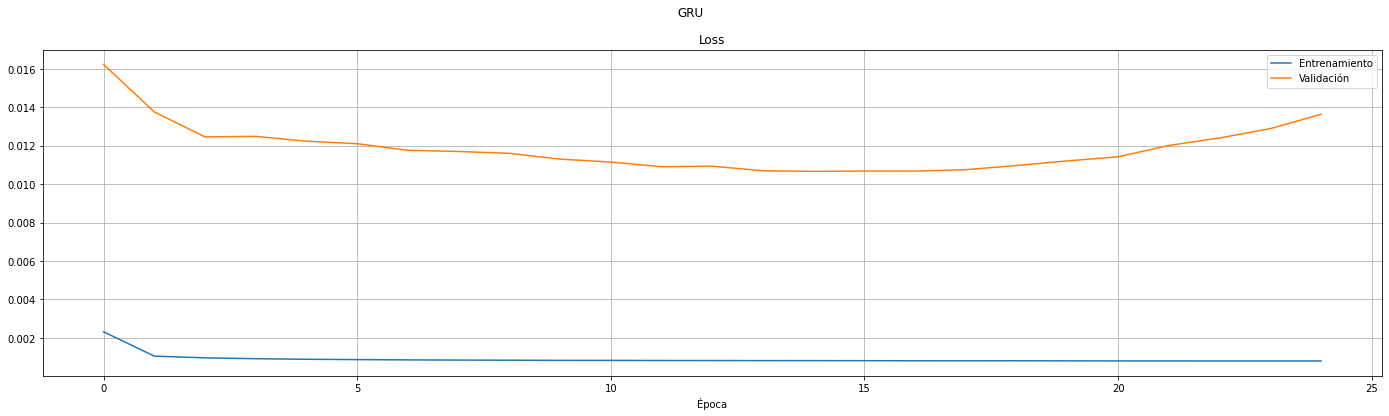

In [207]:
n_trained_epochs = len(history.history['loss'])
fig,axes = plt.subplots(1,1,figsize=(24,6))
plt.suptitle("GRU")
axes.set_title("Loss")
axes.plot(np.arange(n_trained_epochs),history.history['loss'])
axes.plot(np.arange(n_trained_epochs),history.history['val_loss'])
axes.legend(["Entrenamiento","Validación"])
axes.grid(which="Both")
axes.set_xlabel("Época")
plt.show()

MSE: 12.165 
RMSE: 3.488 
MAE: 2.882 
MAPE: 5.865 
R2: -1.721 


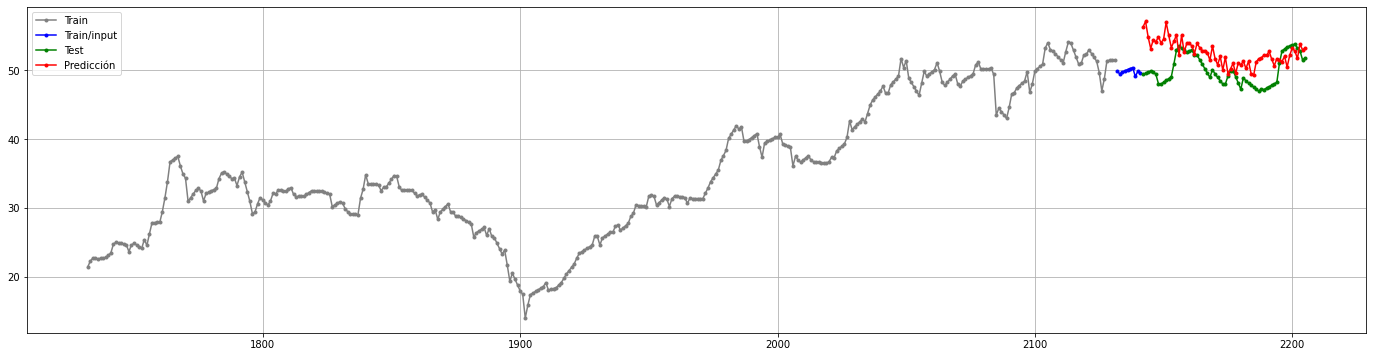

In [209]:
start_time=timeit.default_timer()
model = tf.keras.models.load_model('gru_best.h5')
history,predictions = make_single_prediction_with_rnn(model,scaler,train)
mse,rmse,mae,mape,r2 = report_model2(history,predictions,test)
prediction_time = timeit.default_timer()-start_time

In [210]:
print("Tiempo de Entrenamiento:", training_time)
print("Tiempo de Predicción:", prediction_time)

Tiempo de Entrenamiento: 163.03381290700054
Tiempo de Predicción: 1.2683796839992283


In [212]:
model_metric_results["GRU"] = {
    "MSE": rmse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Tiempo de Entrenamiento": training_time,
    "Tiempo de Predicción": prediction_time,
    "Descripción": "GRU (sin reentrenar)"
}
model_metric_results["GRU"]

{'Descripción': 'GRU (sin reentrenar)',
 'MAE': 2.8816155443356832,
 'MAPE': 5.8647238236990855,
 'MSE': 3.4878595909506784,
 'R2': -1.7205436434911787,
 'RMSE': 3.4878595909506784,
 'Tiempo de Entrenamiento': 163.03381290700054,
 'Tiempo de Predicción': 1.2683796839992283}

### Autoencoder LSTM

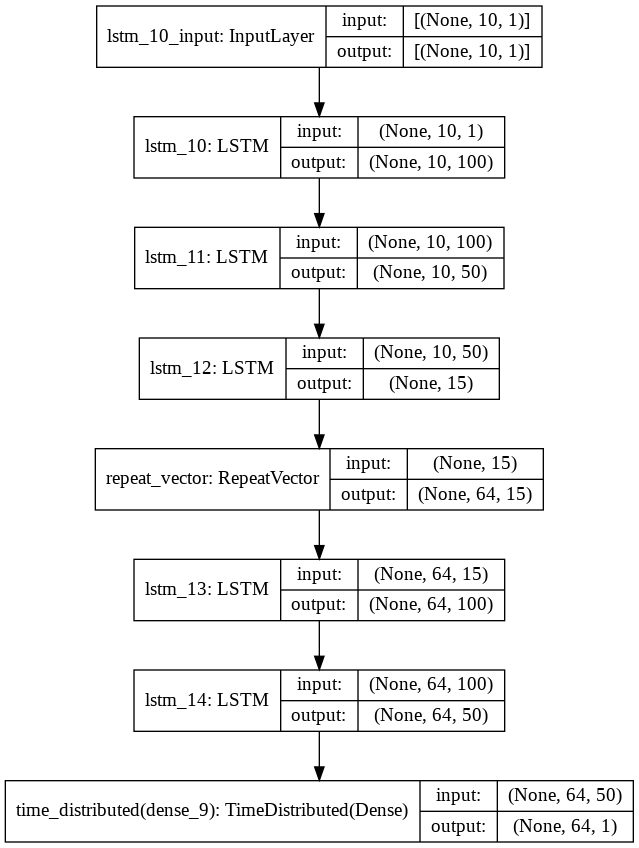

In [213]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(100, input_shape=x_train.shape[-2:], return_sequences=True),
  tf.keras.layers.LSTM(units=50,return_sequences=True),
  tf.keras.layers.LSTM(units=15),
  tf.keras.layers.RepeatVector(y_train.shape[1]),
  tf.keras.layers.LSTM(units=100,return_sequences=True),
  tf.keras.layers.LSTM(units=50,return_sequences=True),
  tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1))
])

model.compile(optimizer='adam', loss='mse')
tf.keras.utils.plot_model(model, show_shapes=True)

In [214]:
EVALUATION_INTERVAL = 100
NUM_EPOCHS = 150

start_time=timeit.default_timer()
history = model.fit(
    train_uv, 
    epochs=NUM_EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_uv,
    validation_steps=50,
    verbose =1,
    callbacks =[
      tf.keras.callbacks.EarlyStopping(
          monitor='val_loss', min_delta=0, patience=10,verbose=1, mode='min'),
      tf.keras.callbacks.ModelCheckpoint('lstm_autoenc_best.h5',
          monitor='val_loss', save_best_only=True, mode='min',verbose=0)
    ])
training_time = timeit.default_timer()-start_time

Epoch 1/150
100/100 [==============================] - 60s 510ms/step - loss: 0.0029 - val_loss: 0.0239
Epoch 2/150
100/100 [==============================] - 47s 466ms/step - loss: 0.0010 - val_loss: 0.0182
Epoch 3/150
100/100 [==============================] - 50s 505ms/step - loss: 9.5429e-04 - val_loss: 0.0285
Epoch 4/150
100/100 [==============================] - 47s 475ms/step - loss: 9.2284e-04 - val_loss: 0.0688
Epoch 5/150
100/100 [==============================] - 47s 472ms/step - loss: 9.0116e-04 - val_loss: 0.2942
Epoch 6/150
100/100 [==============================] - 48s 476ms/step - loss: 8.2248e-04 - val_loss: 0.1570
Epoch 7/150
100/100 [==============================] - 50s 498ms/step - loss: 7.6133e-04 - val_loss: 0.1794
Epoch 8/150
100/100 [==============================] - 48s 478ms/step - loss: 7.4612e-04 - val_loss: 0.1671
Epoch 9/150
100/100 [==============================] - 47s 473ms/step - loss: 7.4422e-04 - val_loss: 0.1546
Epoch 10/150
100/100 [==============

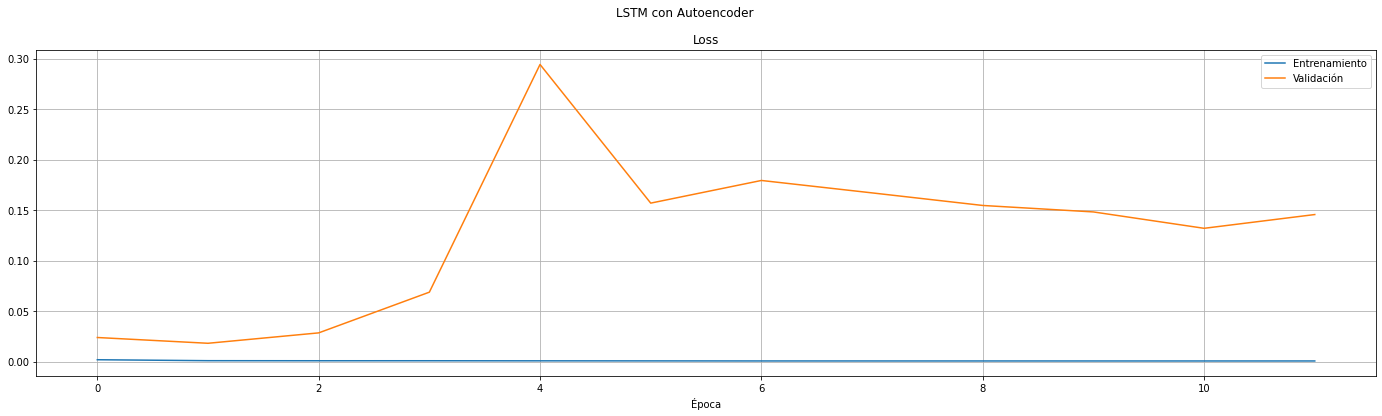

In [215]:
n_trained_epochs = len(history.history['loss'])
fig,axes = plt.subplots(1,1,figsize=(24,6))
plt.suptitle("LSTM con Autoencoder")
axes.set_title("Loss")
axes.plot(np.arange(n_trained_epochs),history.history['loss'])
axes.plot(np.arange(n_trained_epochs),history.history['val_loss'])
axes.legend(["Entrenamiento","Validación"])
axes.grid(which="Both")
axes.set_xlabel("Época")
plt.show()

Como la salida tiene un formato distinto de los otros modelos, se modifica la línea que hace el redimensionamiento de $\hat{y}$:

~~~python
yhat = model.predict(input_scaled.reshape(1,WINDOW_SIZE, 1)).reshape(STEPS_TO_PREDICT,1)
~~~

(64, 1)
MSE: 154.999 
RMSE: 12.450 
MAE: 11.287 
MAPE: 22.447 
R2: -33.663 


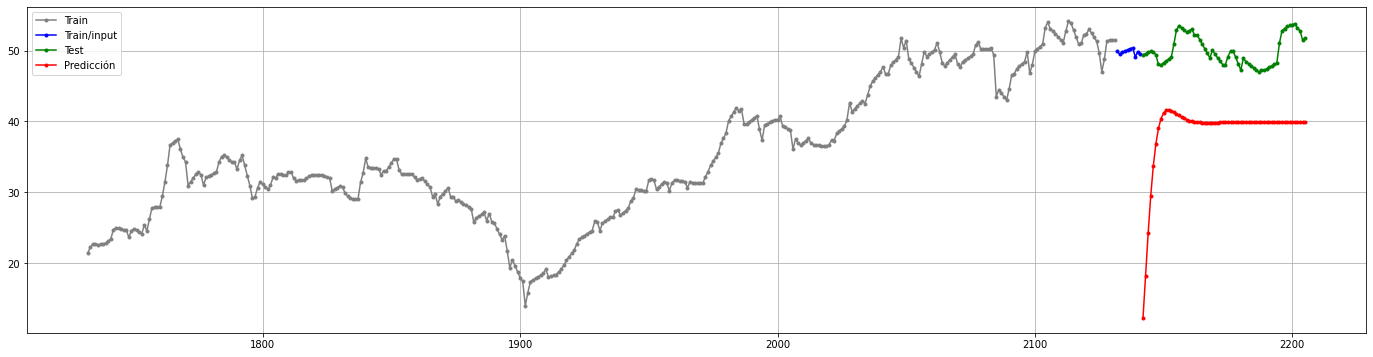

In [226]:
def make_single_prediction_with_rnn2(model,scaler,input):
  history = [x for x in input.values]
  predictions = []
  input_scaled = scaler.transform(input[-WINDOW_SIZE:].values.reshape(-1, 1))  
  yhat = model.predict(input_scaled.reshape(1,WINDOW_SIZE, 1)).reshape(STEPS_TO_PREDICT,1)
  yhat = scaler.inverse_transform(yhat).flatten()
  predictions.extend(yhat)
  predictions = np.array(predictions)
  return history,predictions

start_time=timeit.default_timer()
model = tf.keras.models.load_model('lstm_autoenc_best.h5')
history,predictions = make_single_prediction_with_rnn2(model,scaler,train)
mse,rmse,mae,mape,r2 = report_model2(history,predictions,test)
prediction_time = timeit.default_timer()-start_time

In [227]:
print("Tiempo de Entrenamiento:", training_time)
print("Tiempo de Predicción:", prediction_time)

Tiempo de Entrenamiento: 586.940350967001
Tiempo de Predicción: 3.95197336399724


In [228]:
model_metric_results["LSTM-Autoencoder"] = {
    "MSE": rmse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Tiempo de Entrenamiento": training_time,
    "Tiempo de Predicción": prediction_time,
    "Descripción": "LSTM Autoencoder (sin reentrenar)"
}
model_metric_results["LSTM-Autoencoder"]

{'Descripción': 'LSTM Autoencoder (sin reentrenar)',
 'MAE': 11.286708881537438,
 'MAPE': 22.44730836292059,
 'MSE': 12.44986698542493,
 'R2': -33.663078713727586,
 'RMSE': 12.44986698542493,
 'Tiempo de Entrenamiento': 586.940350967001,
 'Tiempo de Predicción': 3.95197336399724}

### Modelo CNN

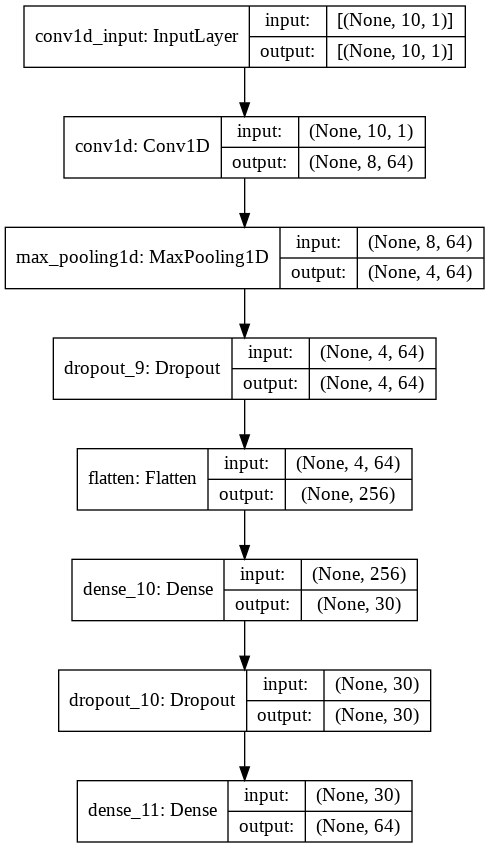

In [229]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu',
input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(tf.keras.layers.MaxPool1D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(30, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(STEPS_TO_PREDICT))
model.compile(optimizer='adam', loss='mse')

model.compile(optimizer='adam', loss='mse')
tf.keras.utils.plot_model(model, show_shapes=True)

In [230]:
EVALUATION_INTERVAL = 100
NUM_EPOCHS = 150

start_time=timeit.default_timer()
history = model.fit(
    train_uv, 
    epochs=NUM_EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_uv,
    validation_steps=50,
    verbose =1,
    callbacks =[
      tf.keras.callbacks.EarlyStopping(
          monitor='val_loss', min_delta=0, patience=10,verbose=1, mode='min'),
      tf.keras.callbacks.ModelCheckpoint('cnn_best.h5',
          monitor='val_loss', save_best_only=True, mode='min',verbose=0)
    ])
training_time = timeit.default_timer()-start_time

Epoch 1/150
100/100 [==============================] - 1s 9ms/step - loss: 0.0047 - val_loss: 0.0202
Epoch 2/150
100/100 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0123
Epoch 3/150
100/100 [==============================] - 1s 7ms/step - loss: 9.5680e-04 - val_loss: 0.0120
Epoch 4/150
100/100 [==============================] - 1s 7ms/step - loss: 8.9629e-04 - val_loss: 0.0138
Epoch 5/150
100/100 [==============================] - 1s 7ms/step - loss: 8.5898e-04 - val_loss: 0.0196
Epoch 6/150
100/100 [==============================] - 1s 8ms/step - loss: 8.3748e-04 - val_loss: 0.0300
Epoch 7/150
100/100 [==============================] - 1s 7ms/step - loss: 8.2200e-04 - val_loss: 0.0446
Epoch 8/150
100/100 [==============================] - 1s 7ms/step - loss: 8.0887e-04 - val_loss: 0.0563
Epoch 9/150
100/100 [==============================] - 1s 7ms/step - loss: 7.9079e-04 - val_loss: 0.0769
Epoch 10/150
100/100 [==============================] - 1s 7ms/

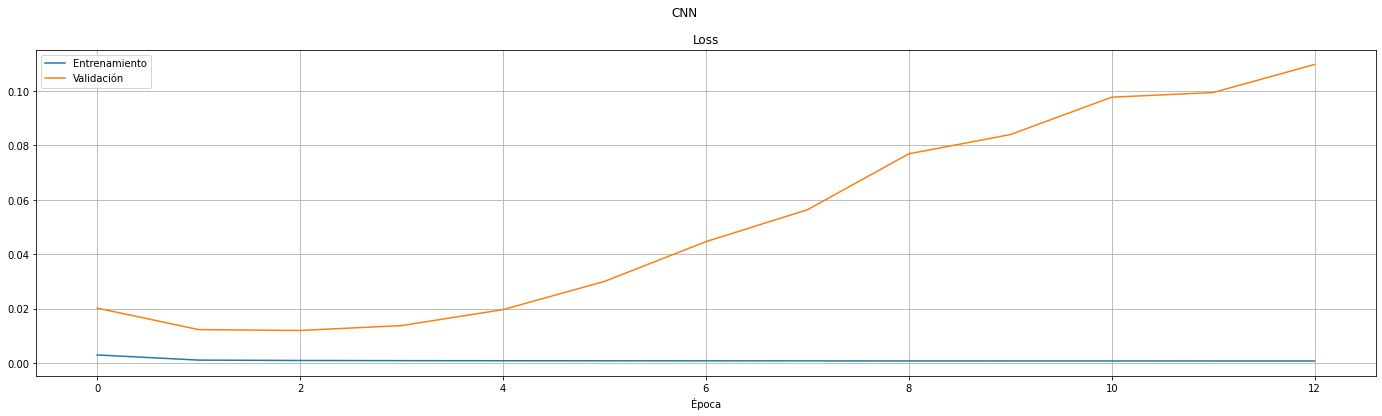

In [231]:
n_trained_epochs = len(history.history['loss'])
fig,axes = plt.subplots(1,1,figsize=(24,6))
plt.suptitle("CNN")
axes.set_title("Loss")
axes.plot(np.arange(n_trained_epochs),history.history['loss'])
axes.plot(np.arange(n_trained_epochs),history.history['val_loss'])
axes.legend(["Entrenamiento","Validación"])
axes.grid(which="Both")
axes.set_xlabel("Época")
plt.show()

(64, 1)
MSE: 9.283 
RMSE: 3.047 
MAE: 2.478 
MAPE: 4.930 
R2: -1.076 


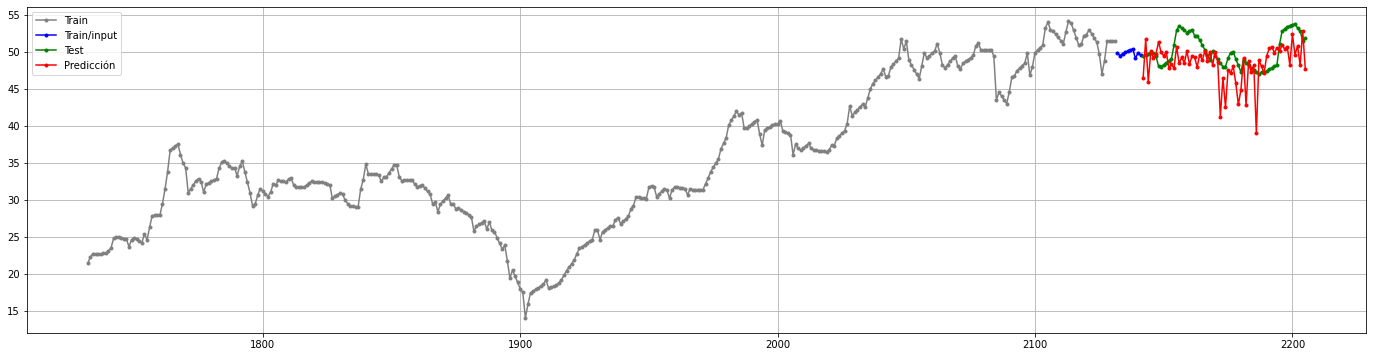

In [232]:
start_time=timeit.default_timer()
model = tf.keras.models.load_model('cnn_best.h5')
history,predictions = make_single_prediction_with_rnn2(model,scaler,train)
mse,rmse,mae,mape,r2 = report_model2(history,predictions,test)
prediction_time = timeit.default_timer()-start_time

In [233]:
print("Tiempo de Entrenamiento:", training_time)
print("Tiempo de Predicción:", prediction_time)

Tiempo de Entrenamiento: 9.831834774995514
Tiempo de Predicción: 0.2127354850017582


In [234]:
model_metric_results["CNN"] = {
    "MSE": rmse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Tiempo de Entrenamiento": training_time,
    "Tiempo de Predicción": prediction_time,
    "Descripción": "CNN (sin reentrenar)"
}
model_metric_results["CNN"]

{'Descripción': 'CNN (sin reentrenar)',
 'MAE': 2.477965732145945,
 'MAPE': 4.930029788842842,
 'MSE': 3.046723568707568,
 'R2': -1.0758875049218872,
 'RMSE': 3.046723568707568,
 'Tiempo de Entrenamiento': 9.831834774995514,
 'Tiempo de Predicción': 0.2127354850017582}

### Modelo Prophet

In [236]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from fbprophet import Prophet

In [237]:
def prepare_for_prophet(series,series_col):
  df_prophet = series.to_frame()
  df_prophet['ds'] = df_prophet.index
  df_prophet = df_prophet.rename(columns={series_col: 'y'})
  df_prophet = df_prophet.reset_index()
  df_prophet.drop('Date', inplace=True, axis=1)
  df_prophet.head()
  return df_prophet

train_prophet = prepare_for_prophet(train,series_col)

#### Con Estacionalidad Diaria

In [238]:
start_time=timeit.default_timer()
model = Prophet(daily_seasonality=True)
model = model.fit(train_prophet)
training_time = timeit.default_timer() - start_time

start_time=timeit.default_timer()
future = model.make_future_dataframe(periods=len(test),freq='D',include_history=False)
forecast = model.predict(future)
prediction_time = timeit.default_timer() - start_time

(<Figure size 1728x432 with 1 Axes>,)

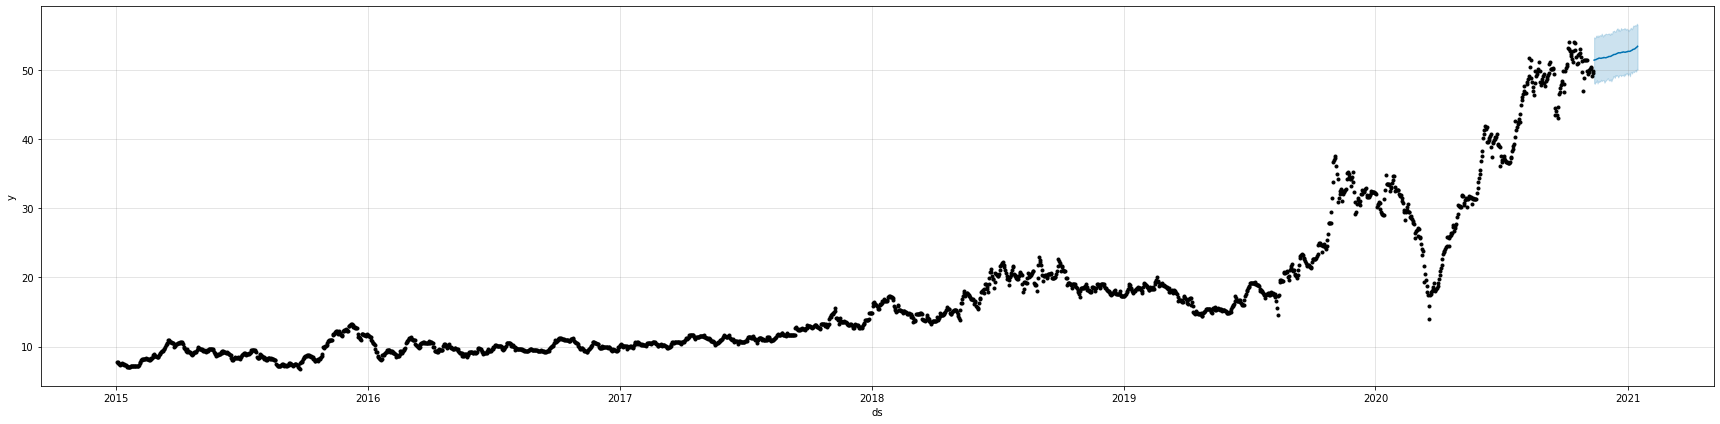

In [239]:
fig,axes=plt.subplots(1,1,figsize=(24,6))
model.plot(forecast,ax=axes),

(<Figure size 648x864 with 4 Axes>,)

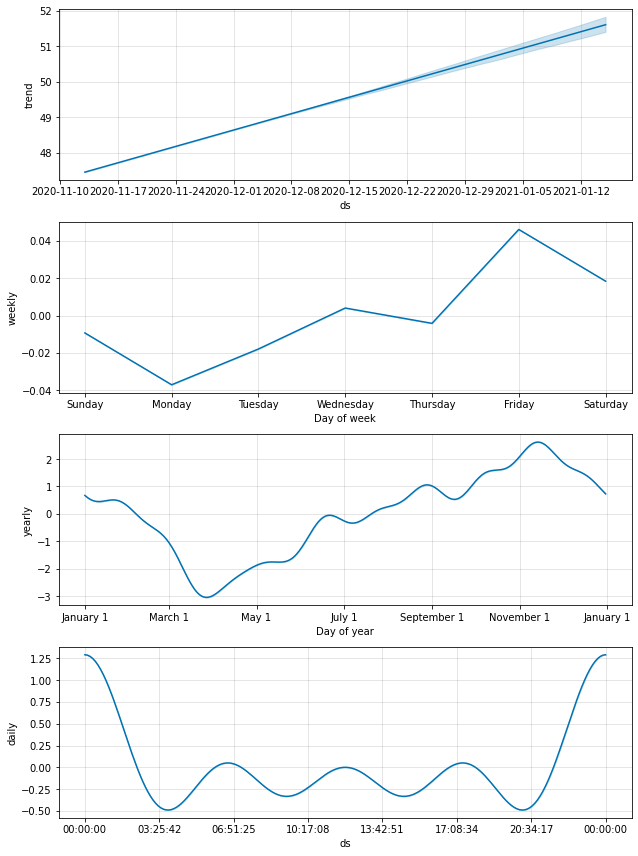

In [240]:
model.plot_components(forecast),

MSE: 9.586 
RMSE: 3.096 
MAE: 2.609 
MAPE: 5.354 
R2: -1.144 


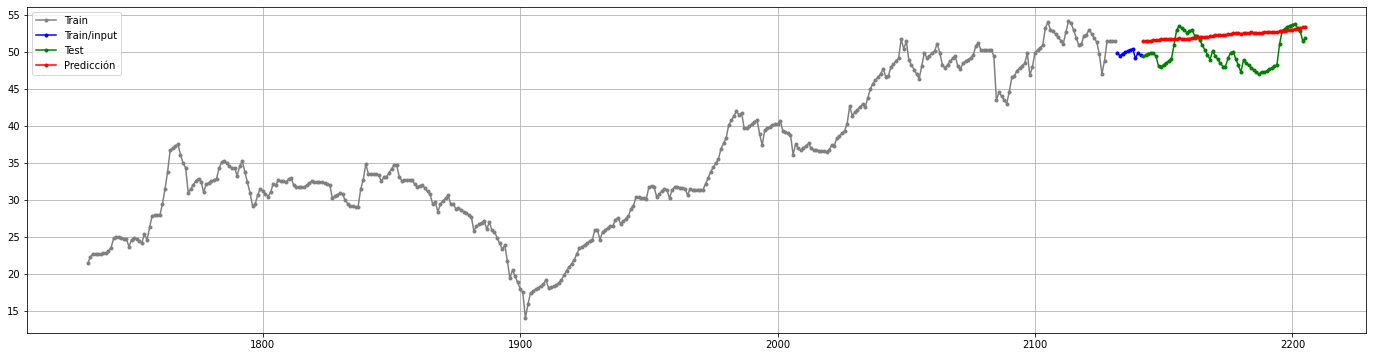

In [241]:
history = [x for x in train.values]
predictions = [x for x in forecast.yhat]
mse,rmse,mae,mape,r2 = report_model2(history,predictions,test)

In [243]:
print("Tiempo de Entrenamiento:", training_time)
print("Tiempo de Predicción:", prediction_time)

model_metric_results["Prophet"] = {
    "MSE": rmse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Tiempo de Entrenamiento": training_time,
    "Tiempo de Predicción": prediction_time,
    "Descripción": "Prophet (con estacionalidad diaria)"
}
model_metric_results["Prophet"]

Tiempo de Entrenamiento: 5.332368711002346
Tiempo de Predicción: 1.8865232589960215


{'Descripción': 'Prophet (con estacionalidad diaria)',
 'MAE': 2.6092873258130895,
 'MAPE': 5.354207341494326,
 'MSE': 3.0961038861428722,
 'R2': -1.1437234538481342,
 'RMSE': 3.0961038861428722,
 'Tiempo de Entrenamiento': 5.332368711002346,
 'Tiempo de Predicción': 1.8865232589960215}

#### Sin Estacionalidad Diaria

In [244]:
start_time=timeit.default_timer()
model = Prophet(daily_seasonality=False)
model = model.fit(train_prophet)
training_time = timeit.default_timer() - start_time

start_time=timeit.default_timer()
future = model.make_future_dataframe(periods=len(test),freq='D',include_history=False)
forecast = model.predict(future)
prediction_time = timeit.default_timer() - start_time

(<Figure size 1728x432 with 1 Axes>,)

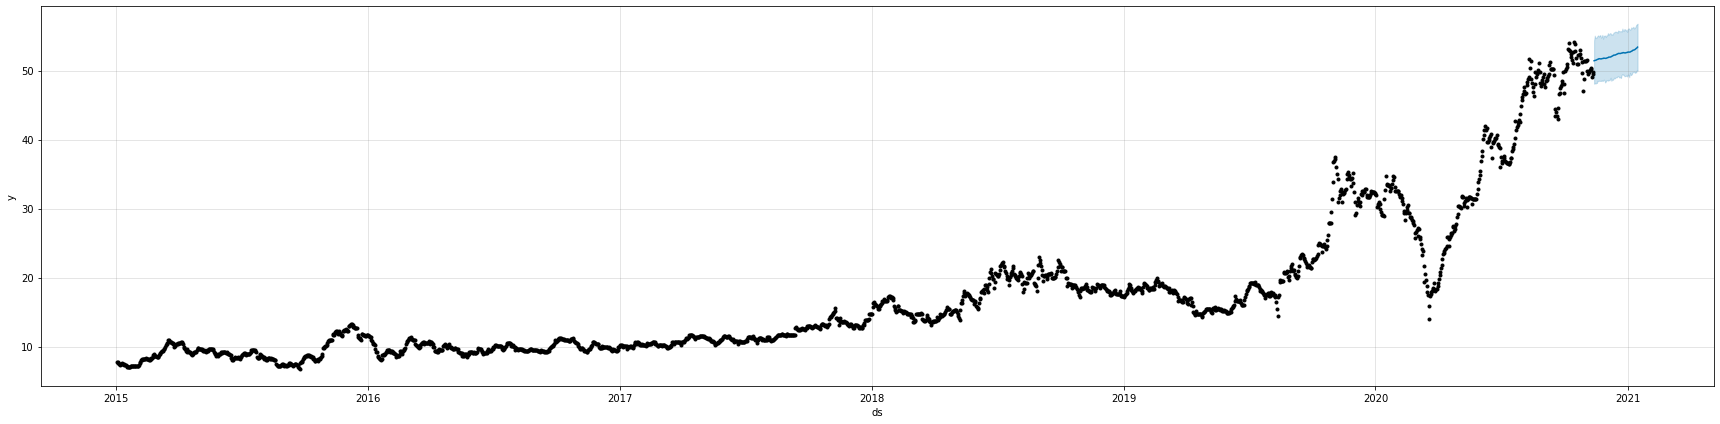

In [245]:
fig,axes=plt.subplots(1,1,figsize=(24,6))
model.plot(forecast,ax=axes),

(<Figure size 648x648 with 3 Axes>,)

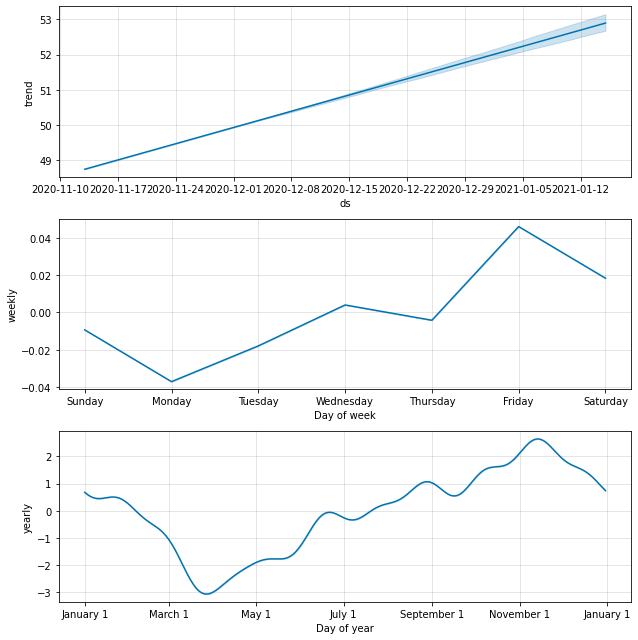

In [246]:
model.plot_components(forecast),

MSE: 9.649 
RMSE: 3.106 
MAE: 2.618 
MAPE: 5.372 
R2: -1.158 


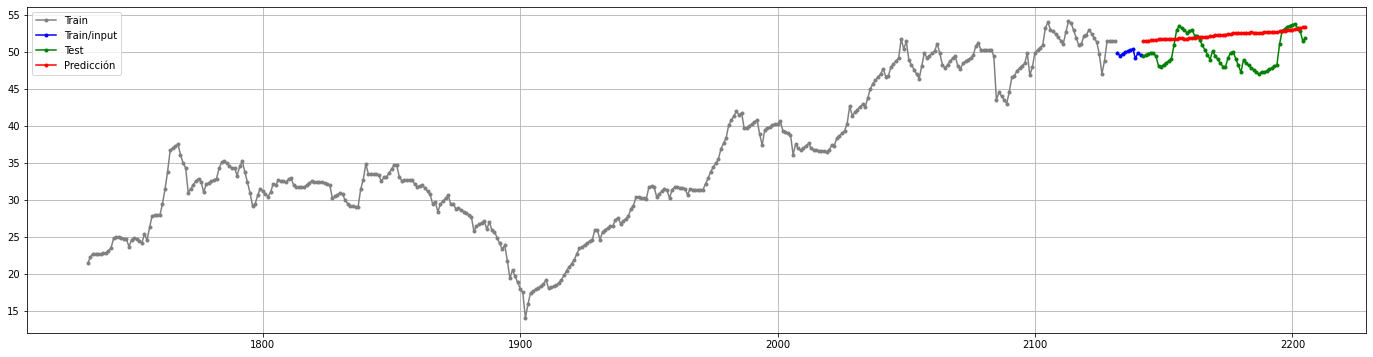

In [247]:
history = [x for x in train.values]
predictions = [x for x in forecast.yhat]
mse,rmse,mae,mape,r2 = report_model2(history,predictions,test)

In [248]:
print("Tiempo de Entrenamiento:", training_time)
print("Tiempo de Predicción:", prediction_time)

model_metric_results["Prophet-NDS"] = {
    "MSE": rmse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R2": r2,
    "Tiempo de Entrenamiento": training_time,
    "Tiempo de Predicción": prediction_time,
    "Descripción": "Prophet (sin estacionalidad diaria)"
}

Tiempo de Entrenamiento: 1.5744243689987343
Tiempo de Predicción: 1.9102084990008734


## Resultados y conclusiones

In [249]:
model_metrics_df = pd.DataFrame.from_dict(model_metric_results, orient='index')
model_metrics_df.sort_values("RMSE",ascending=True)

,MSE,RMSE,MAE,MAPE,R2,Tiempo de Entrenamiento,Tiempo de Predicción,Descripción
SES,2.167736,2.167736,1.787109,3.516799,-0.050873,0.000000,0.019610,Suavizado Exponencial Simple
baseline,2.167736,2.167736,1.787109,3.516799,-0.050873,0.000000,0.000340,Modelo de base (Persistencia)
Holt,2.194472,2.194472,1.787246,3.509308,-0.076956,92.582819,0.222562,Suavizado Exponencial Doble (Holt)
Holt-Winters,2.194472,2.194472,1.787246,3.509308,-0.076956,4627.337234,7529.380116,Suavizado Exponencial Triple (Holt-Winters)
CNN,3.046724,3.046724,2.477966,4.930030,-1.075888,9.831835,0.212735,CNN (sin reentrenar)
Prophet,3.096104,3.096104,2.609287,5.354207,-1.143723,5.332369,1.886523,Prophet (con estacionalidad diaria)
Prophet-NDS,3.106310,3.106310,2.617764,5.371942,-1.157880,1.574424,1.910208,Prophet (sin estacionalidad diaria)
GRU,3.487860,3.487860,2.881616,5.864724,-1.720544,163.033813,1.268380,GRU (sin reentrenar)
LSTM,4.889267,4.889267,4.040259,8.200585,-4.345954,96.415653,1.360025,LSTM (sin reentrenar)
LSTM-Autoencoder,12.449867,12.449867,11.286709,22.447308,-33.663079,586.940351,3.951973,LSTM Autoencoder (sin reentrenar)


In [251]:
#model_metrics_df.to_markdown()

## Bibliografía y Referencias

- [1] "Hands-On Time Series Analysis with Python. From Basics to Bleeding Edge Techniques" - B V VIshwas, Ashish Patel. Apress (2020).
- [2] "Machine Learning for Time Series Forecasting with Python" - Francesca Lazzeri. Wiley (2021).
- [3] "Practical Time Series Analyisis". Avish Pal PKS Prackash. Packt (2017).


